In [1]:
import sys
sys.path.append(r'..//')
from ioMicro import *

In [67]:
def apply_flat_field(dec,tag=r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets\med_col_raw'):
    ### load the immeds
    Icol = dec.XH_pruned[:,:,-2].astype(int)
    uIcols = np.unique(Icol)
    dec.ncols = len(uIcols)
    #save_folder=dec.save_folder#r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
    immeds = []
    for icol in range(dec.ncols):
        fl_med = tag+str(icol)+'.npz'
        if not os.path.exists(fl_med):
            fl_med = fl_med.replace('_raw','')
        dic = np.load(fl_med)
        immed,resc=dic['im'],dic['resc']
        immeds.append(immed)
    dec.immeds = np.array(immeds)
    dec.resc = resc
    
    ### renormalize the brightness according to flatfield
    XH = dec.XH_pruned
    Icol = XH[:,:,-2].astype(int)
    H = dec.XH_pruned[:,:,-3].copy()
    for icol in range(dec.ncols):
        keep = Icol==icol
        immed = dec.immeds[icol].copy()
        immed = immed/np.median(immed)
        x_,y_ = ((XH[keep][:,1:3]/dec.resc).astype(int)%immed.shape).T
        norm_ = immed[x_,y_] 
        H[keep]=H[keep]/norm_
    dec.XH_pruned[:,:,-3] = H


def main_analysisV1(fov,set_,
                   save_folder = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12',
                   save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                   save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpots',
                   drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                   segm_tag = 'A1_LamA_Nup98',redo=False,resc=[2,2,2],
                   drift_semgentation = np.array([  -2.5602207, -486.3025   ,   -5.648471 ])):


    if not os.path.exists(save_folder_all): os.makedirs(save_folder_all)
    save_fl = save_folder_all+os.sep+'saveDecodedFinalV1--'+os.path.basename(save_folder)+'--'+fov.split('.')[0]+'--'+set_+'.npz'
    dec = None
    if not os.path.exists(save_fl) or redo:
        ####### Load in the decoded spot data #############################
        #fov,set_ = 'Conv_zscan__040', '_D16' ################## Change 
        dec = decoder_simple(save_folder,fov,set_)
        dec.ncols = 3
        dec.load_decoded()
        print("Molecules size:",dec.XH_pruned.shape)
        print("Covering reaoduts:",np.unique(dec.XH_pruned[:,:,-1]))
        apply_fine_drift(dec,plt_val=False)
        apply_flat_field(dec)
        #scoresRefT = get_score_per_color(dec)
        scoresRef = np.load(save_fl_ref,allow_pickle=True)
        get_score_withRef(dec,scoresRef,plt_val=True,gene=None,iSs = None,th_min=-10)
        dec.th=-0.5
        plot_statistics(dec)

        ####### Threhold the decoded spot data #############################
        keepf =  dec.scoreA>dec.th ### keep good score
        icodesf = dec.icodesN[keepf]
        XHfpr = dec.XH_pruned[keepf]

        ### Reorganize data  ###############################
        XHf = np.mean(XHfpr,axis=1)
        XF = XHf[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
        #zc,xc,yc,bk-7,a-6,habs-5,hn-4,h-3
        XF[:,-1] = dec.scoreA[keepf]
        XF[:,-2] = np.where(keepf)[0]
        mnD = np.mean(np.linalg.norm((XHf[:,np.newaxis]-XHfpr)[:,:,:3],axis=-1),axis=-1)
        XF[:,-3]=mnD
        mnH = np.mean(np.abs((XHf[:,np.newaxis]-XHfpr)[:,:,-3]),axis=-1)
        XF[:,-4]=mnH
        genesf = dec.gns_names[icodesf]

        ### Apply drift to match the segmentation reference ########################
        def get_drft_dic(fl_all_drift):
            drft,flds,fov_,fl_ref= np.load(fl_all_drift,allow_pickle=True)
            return {('--'.join(fld.split(os.sep)[-2:]) if '--' in os.path.basename(fld) else os.path.basename(fld)):drft_[0] 
                    for fld,drft_ in zip(flds,drft)}

        fl_all_drift = drift_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
        drft_dic_all = get_drft_dic(fl_all_drift)
        fl_all_drift = save_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
        drft_dic_group = get_drft_dic(fl_all_drift)
        key_segm = [key for key in drft_dic_all if segm_tag in key][0]
        key_align = np.intersect1d(list(drft_dic_all.keys()),list(drft_dic_group.keys()))[0]
        if drift_semgentation is None:
            drift_semgentation = drft_dic_all[key_segm]
        th1_to_h0 = drift_semgentation-drft_dic_all[key_align]
        th1_gr = drft_dic_group[key_align]
        tzxyf = th1_gr+th1_to_h0

        XF[:,:3]=XF[:,:3]-tzxyf #### do not add here

        
                
        ### Load in the current fov segmentation ######################################
        ifov = fovs.index(dec.fov)
        coords= coordsf[ifov]
        xIm,xIM,yIm,yIM = coords[0],coords[1],coords[2],coords[3]
        min_ = np.min(XF[:,:3],axis=0)
        max_ = np.max(XF[:,:3],axis=0)

        xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
        ### deal with the case of outside image
        Im = np.array([xIm,yIm])
        min_[1:]=min_[1:]-Im*(Im<0)*resc[1:]
        ### recenter
        xIm,xIM,yIm,yIM = coords[0],coords[1],coords[2],coords[3]
        xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
        XF__=XF[:,:3]-min_
        xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
        dec.im_segm_ = imfsegm[:,xIm:xIM,yIm:yIM]
        dec.XF__ = XF__
        dec.XF = XF
        dec.resc = resc

        #### get cell ids #######################
        def get_cell_id(dec,Xh,resc=[2,2,2],plot_val = False):
            if not hasattr(dec,'im_segm_'): 
                good = np.ones(len(Xh),dtype=bool)
                cells_ = np.zeros(len(Xh),dtype=int)
                return cells_,good
            im_segm = dec.im_segm_
            dec.shapesm = dec.im_segm_.shape
            Xcms = Xh[:,:3]
            Xred = np.round(Xcms/resc).astype(int)
            good = ~np.any((Xred>=dec.shapesm)|(Xred<0),axis=-1)
            Xred = Xred[good]
            if plot_val:
                v = napari.view_points(Xred,size=1.5)
                v.add_labels(im_segm)
            return im_segm[tuple(Xred.T)],good


        cell_id,good =get_cell_id(dec,XF__,resc=resc,plot_val = False)
        #XF_ = np.concatenate([XF[good],cell_id[:,np.newaxis]],axis=-1)
        genesf_ = genesf[good]
        iset = int(dec.set_.split('_D')[-1])
        ifov = int(dec.fov.split('_')[-1].split('.')[0])
        isets = np.array([iset]*len(cell_id))[:,np.newaxis]
        ifovs = np.array([ifov]*len(cell_id))[:,np.newaxis]
        cell_id = cell_id[:,np.newaxis]
        XF_ = np.concatenate([XF[good],cell_id,ifovs,isets],axis=-1)

        #get_xyfov(dec)
        ### add absolute positiuons of molecules in um
        pixel_size = np.array([0.4,0.10833,0.10833])*resc
        XF_ = XF_[:,list(np.arange(XF_.shape[-1]))+[-1,-1,-1]]
        XF_[:,-3:]=((XF_[:,:3]/resc)+[0,coords[0],coords[2]])*pixel_size
        header = ['z','x','y','abs_brightness','cor','brightness','color','mean_bightness_variation','mean_distance_variation',
                  'index_from_XH_pruned','score','cell_id','ifov','iset','z_um_abs','x_um_abs','y_um_abs']


        ##### get info for cells #########################
        if not hasattr(dec,'im_segm_'): dec.im_segm_=np.zeros(np.array([30,3000,3000])//2)
        icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
        #icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))

        cells_abs_pos = (cms+[0,coords[0],coords[2]])*pixel_size

        cellinfo = cms[:,[0,0,0,1,2,0,0,0]]
        cellinfo[:,0]=icells
        cellinfo[:,1]=vols
        cellinfo[:,-3:]=cells_abs_pos

        header_cells = ['cell_id','volm','zc','xc','yc','z_um_abs','x_um_abs','y_um_abs']
        plt.close('all')

        if True:
            np.savez_compressed(save_fl,XF=XF_.astype(np.float32),
                                genes = genesf_,cellinfo=cellinfo.astype(np.float32),header_cells=header_cells,header=header)
        print("Finished",save_fl)
    return dec

In [66]:
set_ = '_D14'
dic_ = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\imfsegm--'+set_+'.npz')################
imfsegm = dic_['imfsegm']
coordsf=dic_['coordsf']
resc = dic_['resc']
dic = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\pos_um_fovs--'+set_+'.npz')##################
pos=dic['pos']
fls=dic['fls']
fovs = [os.path.basename(fl).split('--')[0]for fl in fls]
set_ = '_'+os.path.basename(fls[0]).split('--')[1].split('_')[-1]

In [68]:
save_folders = [r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12',
                r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34',
                r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2']
for fld in save_folders:
    print(os.path.exists(fld))

True
True
True
True
True
True


In [69]:
paramaters = [(fov,set_,save_folder)for fov in fovs for save_folder in save_folders]
len(paramaters)

1536

In [72]:
parms__ = [('Conv_zscan__000', '_D14', 'MERFISH_AnalysisP12'), ('Conv_zscan__007', '_D14', 'MERFISH_AnalysisP12'), ('Conv_zscan__007', '_D14', 'MERFISH_AnalysisP34'), ('Conv_zscan__007', '_D14', 'MERFISH_AnalysisE2'), ('Conv_zscan__008', '_D14', 'MERFISH_AnalysisP12'), ('Conv_zscan__008', '_D14', 'MERFISH_AnalysisP34'), ('Conv_zscan__008', '_D14', 'MERFISH_AnalysisP711'), ('Conv_zscan__008', '_D14', 'MERFISH_AnalysisE2'), ('Conv_zscan__034', '_D14', 'MERFISH_AnalysisP12'), ('Conv_zscan__034', '_D14', 'MERFISH_AnalysisP711'), ('Conv_zscan__034', '_D14', 'MERFISH_AnalysisE2'), ('Conv_zscan__044', '_D14', 'MERFISH_AnalysisE1'), ('Conv_zscan__048', '_D14', 'MERFISH_AnalysisE1'), ('Conv_zscan__052', '_D14', 'MERFISH_AnalysisE1'), ('Conv_zscan__065', '_D14', 'MERFISH_AnalysisE1'), ('Conv_zscan__067', '_D14', 'MERFISH_AnalysisP711'), ('Conv_zscan__105', '_D14', 'MERFISH_AnalysisE1'), ('Conv_zscan__114', '_D14', 'MERFISH_AnalysisE1'), ('Conv_zscan__117', '_D14', 'MERFISH_AnalysisE1'), ('Conv_zscan__118', '_D14', 'MERFISH_AnalysisE1'), ('Conv_zscan__139', '_D14', 'MERFISH_AnalysisP12'), ('Conv_zscan__201', '_D14', 'MERFISH_AnalysisP34'), ('Conv_zscan__231', '_D14', 'MERFISH_AnalysisP56'), ('Conv_zscan__233', '_D14', 'MERFISH_AnalysisP711'), ('Conv_zscan__245', '_D14', 'MERFISH_AnalysisP12'), ('Conv_zscan__245', '_D14', 'MERFISH_AnalysisP56'), ('Conv_zscan__245', '_D14', 'MERFISH_AnalysisE2'), ('Conv_zscan__254', '_D14', 'MERFISH_AnalysisP12')]

Loaded decoded: -1.3386592864990234
Molecules size: (1145208, 4, 10)
Covering reaoduts: [ 3.   4.   5.   9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.  16.
 17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
 31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
 45.  46.  47. ]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:11<00:00,  3.69it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__000 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.26604557037353516
Molecules size: (131237, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 15. 16. 17. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 14.16it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__007 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.13004612922668457
Molecules size: (3294, 4, 10)
Covering reaoduts: [24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 43. 44. 45. 46. 47.]


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 708.26it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,

Failed!!! Conv_zscan__007 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.09635424613952637
Molecules size: (43830, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 345.54it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__007--_D14.npz
Loaded decoded: -0.18445229530334473
Molecules size: (38974, 4, 10)
Covering reaoduts: [ 6.   7.   8.   9.5 10.5 11.5 21.  22.  23.  24.  25.  26.  27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 166.64it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__008 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.09573841094970703
Molecules size: (2093, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.
 33. 34. 35. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1874.63it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__008 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.08262038230895996
Molecules size: (7985, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1054.59it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__008 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.09709024429321289
Molecules size: (18729, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  34.  35.  36.  37.
 38.  40.  41.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 742.37it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__008--_D14.npz
Loaded decoded: -0.2557790279388428
Molecules size: (92579, 4, 10)
Covering reaoduts: [ 0.   1.   2.   9.5 10.5 11.5 21.  22.  23.  24.  25.  26.  27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 63.92it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__034 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.12124800682067871
Molecules size: (52580, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.
 42. 43. 44. 45. 46. 47.]


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 228.23it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__034 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.0758674144744873
Molecules size: (31172, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 514.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__034--_D14.npz
Loaded decoded: -0.6520793437957764
Molecules size: (549864, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.01it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__044--_D14.npz
Loaded decoded: -2.897639274597168
Molecules size: (2114784, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__048--_D14.npz
Loaded decoded: -3.1353838443756104
Molecules size: (2179723, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.85it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__065--_D14.npz
Loaded decoded: -0.4034843444824219
Molecules size: (341956, 4, 10)
Covering reaoduts: [ 3.   3.5  4.   4.5  5.   5.5  6.5  7.5  8.5  9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 38.70it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__067 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -3.7174785137176514
Molecules size: (2607513, 4, 10)
Covering reaoduts: [ 0.   1.   2.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.66it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__105--_D14.npz
Loaded decoded: -3.8684499263763428
Molecules size: (2724186, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.95it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__114--_D14.npz
Loaded decoded: -2.1985788345336914
Molecules size: (1583504, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00, 10.39it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__117--_D14.npz
Loaded decoded: -2.5873329639434814
Molecules size: (1812766, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00,  9.56it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__118--_D14.npz
Failed!!! Conv_zscan__139 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Failed!!! Conv_zscan__201 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -9.741506338119507
Molecules size: (7217033, 4, 10)
Covering reaoduts: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:24<00:00,  1.90it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__231--_D14.npz
Loaded decoded: -7.949907541275024
Molecules size: (6126090, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:24<00:00,  1.90it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__233--_D14.npz
Loaded decoded: -0.2306990623474121
Molecules size: (77018, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 112.48it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__245 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.24706172943115234
Molecules size: (196980, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 59.38it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__245--_D14.npz
Loaded decoded: -0.113037109375
Molecules size: (47035, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  40.  41.  45.  46.  47. ]


100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 239.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__245--_D14.npz
Loaded decoded: -1.7104332447052002
Molecules size: (1289920, 4, 10)
Covering reaoduts: [ 3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.  11.5 12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:03<00:00, 13.52it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/3560665984.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed!!! Conv_zscan__254 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12


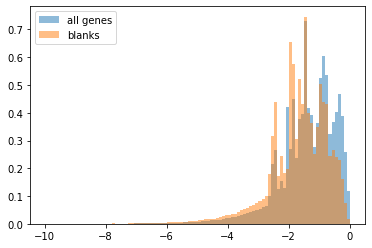

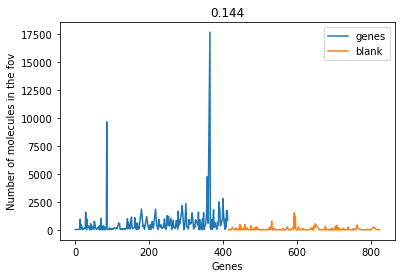

In [74]:
fov,set_,save_folder = 'Conv_zscan__052', '_D14', 'MERFISH_AnalysisE1'
for fov,set_,save_folder in parms__:
    save_folder = {os.path.basename(fld):fld for fld in save_folders}[save_folder]
    try:
        main_analysisV1(fov,set_,
                               save_folder = save_folder,
                               save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                               save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                               drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                               segm_tag = 'A1_LamA_Nup98',redo=False)
    except:
        print("Failed!!!",fov,set_,save_folder)

In [15]:
fov,set_,save_folder = paramaters[1000]
main_analysisV1(fov,set_,
                       save_folder = save_folder,
                       save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                       save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                       drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                       segm_tag = 'A1_LamA_Nup98')

Loaded decoded: -3.09335994720459
Molecules size: (2394170, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  8.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__166--_D14.npz


In [63]:
set_='_D14'
for set_ in ['_D7','_D9','_D13','_D14','_D16']:
    dic = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\pos_um_fovs--'+set_+'.npz')##################
    fls=dic['fls']
    fls__ = glob.glob(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1*'+set_+'.npz')
    len(fls)*6,len(fls__)
    fovs = [os.path.basename(fl).split('--')[0]for fl in fls]
    es = []
    for fl in fls__:
        _,plate_,fov_,set__ = os.path.basename(fl).split('--')
        set__ = set__.split('.')[0]
        es.append((fov_,set__,plate_))
    plates__ = ['MERFISH_AnalysisP12', 'MERFISH_AnalysisP34', 'MERFISH_AnalysisE1', 'MERFISH_AnalysisP56', 'MERFISH_AnalysisP711', 'MERFISH_AnalysisE2']
    all_es = [(fov,set_,pl)for fov in fovs for pl in plates__]
    print([e for e in all_es if e not in es])

[]
[('Conv_zscan__00', '_D9', 'MERFISH_AnalysisP12'), ('Conv_zscan__00', '_D9', 'MERFISH_AnalysisP34'), ('Conv_zscan__00', '_D9', 'MERFISH_AnalysisE1'), ('Conv_zscan__00', '_D9', 'MERFISH_AnalysisP56'), ('Conv_zscan__00', '_D9', 'MERFISH_AnalysisP711'), ('Conv_zscan__00', '_D9', 'MERFISH_AnalysisE2'), ('Conv_zscan__03', '_D9', 'MERFISH_AnalysisP12'), ('Conv_zscan__03', '_D9', 'MERFISH_AnalysisP34'), ('Conv_zscan__03', '_D9', 'MERFISH_AnalysisE1'), ('Conv_zscan__03', '_D9', 'MERFISH_AnalysisP56'), ('Conv_zscan__03', '_D9', 'MERFISH_AnalysisP711'), ('Conv_zscan__03', '_D9', 'MERFISH_AnalysisE2'), ('Conv_zscan__04', '_D9', 'MERFISH_AnalysisP56'), ('Conv_zscan__09', '_D9', 'MERFISH_AnalysisP711'), ('Conv_zscan__11', '_D9', 'MERFISH_AnalysisP34'), ('Conv_zscan__21', '_D9', 'MERFISH_AnalysisP12'), ('Conv_zscan__25', '_D9', 'MERFISH_AnalysisP12'), ('Conv_zscan__26', '_D9', 'MERFISH_AnalysisP12'), ('Conv_zscan__26', '_D9', 'MERFISH_AnalysisP34'), ('Conv_zscan__26', '_D9', 'MERFISH_AnalysisP711

[('Conv_zscan__000', '_D14', 'MERFISH_AnalysisP12'),
 ('Conv_zscan__007', '_D14', 'MERFISH_AnalysisP12'),
 ('Conv_zscan__007', '_D14', 'MERFISH_AnalysisP34'),
 ('Conv_zscan__007', '_D14', 'MERFISH_AnalysisE2'),
 ('Conv_zscan__008', '_D14', 'MERFISH_AnalysisP12'),
 ('Conv_zscan__008', '_D14', 'MERFISH_AnalysisP34'),
 ('Conv_zscan__008', '_D14', 'MERFISH_AnalysisP711'),
 ('Conv_zscan__008', '_D14', 'MERFISH_AnalysisE2'),
 ('Conv_zscan__034', '_D14', 'MERFISH_AnalysisP12'),
 ('Conv_zscan__034', '_D14', 'MERFISH_AnalysisP711'),
 ('Conv_zscan__034', '_D14', 'MERFISH_AnalysisE2'),
 ('Conv_zscan__044', '_D14', 'MERFISH_AnalysisE1'),
 ('Conv_zscan__048', '_D14', 'MERFISH_AnalysisE1'),
 ('Conv_zscan__052', '_D14', 'MERFISH_AnalysisE1'),
 ('Conv_zscan__065', '_D14', 'MERFISH_AnalysisE1'),
 ('Conv_zscan__067', '_D14', 'MERFISH_AnalysisP711'),
 ('Conv_zscan__105', '_D14', 'MERFISH_AnalysisE1'),
 ('Conv_zscan__114', '_D14', 'MERFISH_AnalysisE1'),
 ('Conv_zscan__117', '_D14', 'MERFISH_AnalysisE1'),


In [61]:
txt = """0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5""".replace('\n',' ').replace('  ',' ').replace('  ',' ').split(' ')
np.setdiff1d(np.arange(48),np.unique(np.array(txt,dtype=float).astype(int)))

array([10])

In [64]:
fov,set_,save_folder = 'Conv_zscan__052', '_D14', 'MERFISH_AnalysisE1'
for fov,set_,save_folder in 
save_folder = {os.path.basename(fld):fld for fld in save_folders}[save_folder]
main_analysisV1(fov,set_,
                       save_folder = save_folder,
                       save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                       save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                       drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                       segm_tag = 'A1_LamA_Nup98')

Loaded decoded: -0.972254753112793
Molecules size: (825237, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 17.58it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__052--_D14.npz


In [ ]:
('Conv_zscan__195', '_D16', 'MERFISH_AnalysisP12'),
 ('Conv_zscan__206', '_D16', 'MERFISH_AnalysisE1')

In [65]:
len(fls__),len(paramaters)

(1545, 1146)

  0%|                                                                                         | 0/1146 [00:00<?, ?it/s]

Loaded decoded: -13.298516988754272
Molecules size: (7642589, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.26it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__000--_D13.npz


  0%|                                                                              | 1/1146 [01:23<26:40:55, 83.89s/it]

Loaded decoded: -7.06131649017334
Molecules size: (5081810, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.
 45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.31it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__000--_D13.npz


  0%|▏                                                                             | 2/1146 [02:19<21:24:39, 67.38s/it]

Loaded decoded: -3.1419081687927246
Molecules size: (1870219, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  0%|▏                                                                             | 3/1146 [02:52<16:19:24, 51.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__000--_D13.npz
Loaded decoded: -8.94820523262024
Molecules size: (6490008, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  28.  29.  30.  31.
 32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
 46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.54it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__000--_D13.npz


  0%|▎                                                                             | 4/1146 [04:00<18:23:43, 57.99s/it]

Loaded decoded: -8.99743390083313
Molecules size: (5225525, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  28.  29.
 30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
 44.  45.  46.  47. ]



  0%|▎                                                                             | 5/1146 [05:08<19:33:41, 61.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__000--_D13.npz
Loaded decoded: -2.7014412879943848
Molecules size: (1926218, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.5 31.5 32.5 33.  34.  35.  36.  37.  38.  39.
 40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▍                                                                             | 6/1146 [05:36<15:55:33, 50.29s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__000--_D13.npz
Loaded decoded: -33.84116220474243
Molecules size: (22282839, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:38<00:00,  1.24it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__001--_D13.npz


  1%|▍                                                                             | 7/1146 [08:34<29:06:33, 92.00s/it]

Loaded decoded: -20.204660654067993
Molecules size: (13566226, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.
 45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.96it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__001--_D13.npz


  1%|▌                                                                            | 8/1146 [10:36<32:04:44, 101.48s/it]

Loaded decoded: -9.027612686157227
Molecules size: (5480846, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|▌                                                                             | 9/1146 [11:35<27:51:26, 88.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__001--_D13.npz
Loaded decoded: -26.22948431968689
Molecules size: (18451585, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.56it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__001--_D13.npz


  1%|▋                                                                           | 10/1146 [14:01<33:30:01, 106.16s/it]

Loaded decoded: -20.50239324569702
Molecules size: (13155844, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  12.5
 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__001--_D13.npz


  1%|▋                                                                           | 11/1146 [15:55<34:12:54, 108.52s/it]

Loaded decoded: -7.865141868591309
Molecules size: (5304801, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▊                                                                            | 12/1146 [16:50<29:00:55, 92.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__001--_D13.npz
Loaded decoded: -21.95634889602661
Molecules size: (13429439, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.08it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__002--_D13.npz


  1%|▊                                                                            | 13/1146 [18:43<30:59:10, 98.46s/it]

Loaded decoded: -13.600436925888062
Molecules size: (7821950, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.
 45.5 46.  46.5 47.  47.5]



  1%|▉                                                                            | 14/1146 [20:00<28:55:03, 91.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__002--_D13.npz
Loaded decoded: -4.095238924026489
Molecules size: (2751777, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|█                                                                            | 15/1146 [20:35<23:31:34, 74.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__002--_D13.npz
Loaded decoded: -15.928914785385132
Molecules size: (11069690, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.53it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__002--_D13.npz


  1%|█                                                                            | 16/1146 [22:07<25:05:19, 79.93s/it]

Loaded decoded: -12.389163255691528
Molecules size: (8956418, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   7.
  8.   9.  10.  11.  12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5
 24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.
 38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.83it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__002--_D13.npz


  1%|█▏                                                                           | 17/1146 [23:28<25:13:42, 80.45s/it]

Loaded decoded: -4.0644025802612305
Molecules size: (2753589, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▏                                                                           | 18/1146 [24:05<21:07:40, 67.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__002--_D13.npz
Loaded decoded: -15.608816146850586
Molecules size: (9162727, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.84it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__003--_D13.npz


  2%|█▎                                                                           | 19/1146 [25:33<22:58:22, 73.38s/it]

Loaded decoded: -6.632072925567627
Molecules size: (4461798, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.
 41.5 42.  43.  44.  45.  45.5 46.  46.5 47.  47.5]



  2%|█▎                                                                           | 20/1146 [26:20<20:32:17, 65.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__003--_D13.npz
Loaded decoded: -1.9377107620239258
Molecules size: (1207663, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▍                                                                           | 21/1146 [26:42<16:24:18, 52.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__003--_D13.npz
Loaded decoded: -6.8265814781188965
Molecules size: (4757819, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▍                                                                           | 22/1146 [27:28<15:47:54, 50.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__003--_D13.npz
Loaded decoded: -6.0274012088775635
Molecules size: (4233710, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▌                                                                           | 23/1146 [28:13<15:15:52, 48.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__003--_D13.npz
Loaded decoded: -1.8800432682037354
Molecules size: (1244967, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▌                                                                           | 24/1146 [28:36<12:48:30, 41.10s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__003--_D13.npz
Loaded decoded: -20.51796841621399
Molecules size: (12984646, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.15it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__004--_D13.npz


  2%|█▋                                                                           | 25/1146 [30:26<19:12:23, 61.68s/it]

Loaded decoded: -10.786784410476685
Molecules size: (6863795, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▋                                                                           | 26/1146 [31:34<19:45:51, 63.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__004--_D13.npz
Loaded decoded: -6.65992546081543
Molecules size: (2402610, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▊                                                                           | 27/1146 [31:48<15:09:24, 48.76s/it]

Failed at: Conv_zscan__004 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -11.157391786575317
Molecules size: (8105858, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__004--_D13.npz


  2%|█▉                                                                           | 28/1146 [33:02<17:29:09, 56.31s/it]

Loaded decoded: -9.700584888458252
Molecules size: (7007192, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|█▉                                                                           | 29/1146 [34:06<18:14:11, 58.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__004--_D13.npz
Loaded decoded: -4.56199312210083
Molecules size: (2296312, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██                                                                           | 30/1146 [34:39<15:45:46, 50.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__004--_D13.npz
Loaded decoded: -24.254819869995117
Molecules size: (15457753, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.75it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__005--_D13.npz


  3%|██                                                                           | 31/1146 [36:49<23:07:42, 74.67s/it]

Loaded decoded: -10.187037944793701
Molecules size: (6811593, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  43.
 44.  45.  45.5 46.  46.5 47.  47.5]



  3%|██▏                                                                          | 32/1146 [37:57<22:28:29, 72.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__005--_D13.npz
Loaded decoded: -6.785848617553711
Molecules size: (2418933, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▏                                                                          | 33/1146 [38:11<17:01:03, 55.04s/it]

Failed at: Conv_zscan__005 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -12.164097785949707
Molecules size: (8721959, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.98it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__005--_D13.npz


  3%|██▎                                                                          | 34/1146 [39:27<18:55:43, 61.28s/it]

Loaded decoded: -11.17883038520813
Molecules size: (7599632, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▎                                                                          | 35/1146 [40:35<19:36:12, 63.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__005--_D13.npz
Loaded decoded: -3.6094970703125
Molecules size: (2421151, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██▍                                                                          | 36/1146 [41:07<16:39:54, 54.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__005--_D13.npz
Loaded decoded: -22.433380126953125
Molecules size: (13636283, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.94it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__006--_D13.npz


  3%|██▍                                                                          | 37/1146 [43:05<22:31:31, 73.12s/it]

Loaded decoded: -9.917711973190308
Molecules size: (6217659, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.
 41.5 42.  43.  44.  45.  45.5 46.  46.5 47.  47.5]



  3%|██▌                                                                          | 38/1146 [44:07<21:25:49, 69.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__006--_D13.npz
Loaded decoded: -5.552911996841431
Molecules size: (2730891, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▌                                                                          | 39/1146 [44:44<18:25:29, 59.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__006--_D13.npz
Loaded decoded: -10.639998435974121
Molecules size: (7406784, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.44it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__006--_D13.npz


  3%|██▋                                                                          | 40/1146 [45:54<19:22:26, 63.06s/it]

Loaded decoded: -9.422789335250854
Molecules size: (6181916, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|██▊                                                                          | 41/1146 [46:58<19:24:48, 63.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__006--_D13.npz
Loaded decoded: -3.4522876739501953
Molecules size: (2122591, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▊                                                                          | 42/1146 [47:28<16:21:49, 53.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__006--_D13.npz
Loaded decoded: -5.688549995422363
Molecules size: (3882936, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▉                                                                          | 43/1146 [48:10<15:19:06, 50.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__007--_D13.npz
Loaded decoded: -1.803419589996338
Molecules size: (1196853, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▉                                                                          | 44/1146 [48:35<12:56:41, 42.29s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__007--_D13.npz
Loaded decoded: -0.7503061294555664
Molecules size: (468922, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|███                                                                          | 45/1146 [48:51<10:32:00, 34.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__007--_D13.npz
Loaded decoded: -3.3989667892456055
Molecules size: (1906900, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███▏                                                                          | 46/1146 [49:19<9:57:36, 32.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__007--_D13.npz
Loaded decoded: -2.4841971397399902
Molecules size: (1678960, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 45. 46. 47.]



  4%|███▏                                                                          | 47/1146 [49:45<9:20:28, 30.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__007--_D13.npz
Loaded decoded: -1.8331186771392822
Molecules size: (740783, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███▎                                                                          | 48/1146 [50:06<8:25:41, 27.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__007--_D13.npz
Loaded decoded: -22.58886194229126
Molecules size: (14050254, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.94it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__008--_D13.npz


  4%|███▎                                                                         | 49/1146 [52:06<16:50:47, 55.29s/it]

Loaded decoded: -11.910471200942993
Molecules size: (6201630, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|███▎                                                                         | 50/1146 [53:15<18:06:26, 59.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__008--_D13.npz
Loaded decoded: -4.127269744873047
Molecules size: (2589429, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|███▍                                                                         | 51/1146 [53:50<15:52:26, 52.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__008--_D13.npz
Loaded decoded: -11.85260558128357
Molecules size: (7388550, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▍                                                                         | 52/1146 [54:59<17:24:19, 57.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__008--_D13.npz
Loaded decoded: -9.296614646911621
Molecules size: (6630425, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▌                                                                         | 53/1146 [56:01<17:47:03, 58.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__008--_D13.npz
Loaded decoded: -5.878238916397095
Molecules size: (2432267, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▋                                                                         | 54/1146 [56:37<15:43:51, 51.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__008--_D13.npz
Loaded decoded: -15.100317239761353
Molecules size: (10115390, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__009--_D13.npz


  5%|███▋                                                                         | 55/1146 [58:08<19:16:27, 63.60s/it]

Loaded decoded: -10.620708227157593
Molecules size: (4658499, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



  5%|███▊                                                                         | 56/1146 [59:03<18:28:11, 61.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__009--_D13.npz
Loaded decoded: -2.942466974258423
Molecules size: (2028536, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▊                                                                         | 57/1146 [59:37<16:01:51, 52.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__009--_D13.npz
Loaded decoded: -8.599831819534302
Molecules size: (5953617, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▊                                                                       | 58/1146 [1:00:38<16:43:20, 55.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__009--_D13.npz
Loaded decoded: -8.369309663772583
Molecules size: (5700203, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  4.00it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__009--_D13.npz


  5%|███▊                                                                       | 59/1146 [1:01:36<16:59:50, 56.29s/it]

Loaded decoded: -3.2621214389801025
Molecules size: (2047870, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▉                                                                       | 60/1146 [1:02:06<14:33:27, 48.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__009--_D13.npz
Loaded decoded: -12.82111144065857
Molecules size: (8377321, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▉                                                                       | 61/1146 [1:03:23<17:08:18, 56.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__010--_D13.npz
Loaded decoded: -7.9639670848846436
Molecules size: (3428633, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.
 47.5]



  5%|████                                                                       | 62/1146 [1:04:08<16:02:25, 53.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__010--_D13.npz
Loaded decoded: -2.96858811378479
Molecules size: (1559427, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|████                                                                       | 63/1146 [1:04:34<13:37:11, 45.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__010--_D13.npz
Loaded decoded: -9.450791835784912
Molecules size: (4849692, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▏                                                                      | 64/1146 [1:05:27<14:16:47, 47.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__010--_D13.npz
Loaded decoded: -6.875114917755127
Molecules size: (4593644, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▎                                                                      | 65/1146 [1:06:21<14:48:41, 49.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__010--_D13.npz
Loaded decoded: -2.70420503616333
Molecules size: (1797561, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▎                                                                      | 66/1146 [1:06:52<13:10:52, 43.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__010--_D13.npz
Loaded decoded: -9.246963024139404
Molecules size: (4623164, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▍                                                                      | 67/1146 [1:07:43<13:47:57, 46.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__011--_D13.npz
Loaded decoded: -5.689025163650513
Molecules size: (2173508, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  34.  35.  36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▍                                                                      | 68/1146 [1:08:21<13:05:40, 43.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__011--_D13.npz
Loaded decoded: -1.5418760776519775
Molecules size: (1001391, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▌                                                                      | 69/1146 [1:08:43<11:07:34, 37.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__011--_D13.npz
Loaded decoded: -4.034351348876953
Molecules size: (2870417, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▌                                                                      | 70/1146 [1:09:20<11:05:34, 37.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__011--_D13.npz
Loaded decoded: -4.268862247467041
Molecules size: (2814954, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▋                                                                      | 71/1146 [1:09:57<11:03:16, 37.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__011--_D13.npz
Loaded decoded: -1.6890673637390137
Molecules size: (1085251, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▊                                                                       | 72/1146 [1:10:21<9:51:53, 33.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__011--_D13.npz
Loaded decoded: -45.29145073890686
Molecules size: (27752099, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:46<00:00,  1.03it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__012--_D13.npz


  6%|████▊                                                                      | 73/1146 [1:14:07<27:06:15, 90.94s/it]

Loaded decoded: -24.892112255096436
Molecules size: (14163994, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.86it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__012--_D13.npz


  6%|████▊                                                                     | 74/1146 [1:16:20<30:50:27, 103.57s/it]

Loaded decoded: -7.59717321395874
Molecules size: (5127286, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|████▉                                                                      | 75/1146 [1:17:18<26:45:33, 89.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__012--_D13.npz
Loaded decoded: -24.755642414093018
Molecules size: (17063243, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.71it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__012--_D13.npz


  7%|████▉                                                                     | 76/1146 [1:19:40<31:22:32, 105.56s/it]

Loaded decoded: -24.07951807975769
Molecules size: (15465405, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.73it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__012--_D13.npz


  7%|████▉                                                                     | 77/1146 [1:21:54<33:55:10, 114.23s/it]

Loaded decoded: -10.442214965820312
Molecules size: (6605297, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████                                                                     | 78/1146 [1:23:03<29:48:34, 100.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__012--_D13.npz
Loaded decoded: -35.53312039375305
Molecules size: (21084886, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████                                                                     | 79/1146 [1:26:01<36:39:41, 123.69s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__013--_D13.npz
Loaded decoded: -15.9522385597229
Molecules size: (10738485, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.
  8.5  9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  43.  44.  45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.38it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__013--_D13.npz


  7%|█████▏                                                                    | 80/1146 [1:27:42<34:40:18, 117.09s/it]

Loaded decoded: -7.014016151428223
Molecules size: (3593251, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:08<00:00,  5.54it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__013--_D13.npz


  7%|█████▎                                                                     | 81/1146 [1:28:32<28:37:01, 96.73s/it]

Loaded decoded: -16.905102252960205
Molecules size: (11805521, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.33it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__013--_D13.npz


  7%|█████▎                                                                     | 82/1146 [1:30:17<29:19:35, 99.23s/it]

Loaded decoded: -16.17066478729248
Molecules size: (10846244, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▍                                                                     | 83/1146 [1:31:58<29:27:14, 99.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__013--_D13.npz
Loaded decoded: -7.0527942180633545
Molecules size: (4247700, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████▍                                                                     | 84/1146 [1:32:53<25:28:32, 86.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__013--_D13.npz
Loaded decoded: -20.276241540908813
Molecules size: (13966189, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.85it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__014--_D13.npz


  7%|█████▌                                                                     | 85/1146 [1:34:51<28:18:02, 96.03s/it]

Loaded decoded: -11.53063178062439
Molecules size: (6455693, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|█████▋                                                                     | 86/1146 [1:36:03<26:06:24, 88.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__014--_D13.npz
Loaded decoded: -2.6099727153778076
Molecules size: (1749692, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|█████▋                                                                     | 87/1146 [1:36:30<20:38:12, 70.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__014--_D13.npz
Loaded decoded: -11.259390115737915
Molecules size: (7640974, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.39it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__014--_D13.npz


  8%|█████▊                                                                     | 88/1146 [1:37:42<20:49:47, 70.88s/it]

Loaded decoded: -9.364248514175415
Molecules size: (6533301, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.73it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__014--_D13.npz


  8%|█████▊                                                                     | 89/1146 [1:38:44<20:01:29, 68.20s/it]

Loaded decoded: -3.806391477584839
Molecules size: (2565934, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  8%|█████▉                                                                     | 90/1146 [1:39:19<17:03:32, 58.16s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__014--_D13.npz
Loaded decoded: -44.43428063392639
Molecules size: (25545483, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:50<00:00,  1.06s/it]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__015--_D13.npz


  8%|█████▉                                                                    | 91/1146 [1:42:58<31:10:41, 106.39s/it]

Loaded decoded: -7.358476161956787
Molecules size: (4903482, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|██████                                                                     | 93/1146 [1:43:54<20:31:29, 70.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__015--_D13.npz
Loaded decoded: -22.188754081726074
Molecules size: (15227337, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|██████▏                                                                    | 94/1146 [1:46:03<24:46:45, 84.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__015--_D13.npz
Loaded decoded: -21.390199661254883
Molecules size: (13642593, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.05it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__015--_D13.npz


  8%|██████▏                                                                    | 95/1146 [1:48:04<27:31:29, 94.28s/it]

Loaded decoded: -8.48576831817627
Molecules size: (5506252, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__015--_D13.npz


  8%|██████▎                                                                    | 96/1146 [1:49:07<24:59:47, 85.70s/it]

Loaded decoded: -35.45808005332947
Molecules size: (20967495, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.36it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__016--_D13.npz


  8%|██████▎                                                                   | 97/1146 [1:52:02<32:16:57, 110.79s/it]

Loaded decoded: -5.054718494415283
Molecules size: (3356434, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  9%|██████▍                                                                    | 99/1146 [1:52:46<20:44:53, 71.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__016--_D13.npz
Loaded decoded: -17.00891399383545
Molecules size: (11694907, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.42it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__016--_D13.npz


  9%|██████▍                                                                   | 100/1146 [1:54:26<22:42:50, 78.17s/it]

Loaded decoded: -14.966764450073242
Molecules size: (10205511, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.55it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__016--_D13.npz


  9%|██████▌                                                                   | 101/1146 [1:56:00<23:53:04, 82.28s/it]

Loaded decoded: -6.476716756820679
Molecules size: (3865525, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▌                                                                   | 102/1146 [1:56:47<21:05:26, 72.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__016--_D13.npz
Loaded decoded: -42.193445444107056
Molecules size: (27811473, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:46<00:00,  1.04it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__017--_D13.npz


  9%|██████▌                                                                  | 103/1146 [2:00:27<32:55:37, 113.65s/it]

Loaded decoded: -25.016600131988525
Molecules size: (15002236, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.77it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__017--_D13.npz


  9%|██████▌                                                                  | 104/1146 [2:02:43<34:44:38, 120.04s/it]

Loaded decoded: -26.609312772750854
Molecules size: (18658401, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.  10.  11.  12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  19.  20.  21.  22.  23.  24.  25.  26.
 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
 41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.58it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__017--_D13.npz


  9%|██████▊                                                                  | 106/1146 [2:05:16<28:59:47, 100.37s/it]

Loaded decoded: -22.762765169143677
Molecules size: (15552986, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.73it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__017--_D13.npz


  9%|██████▊                                                                  | 107/1146 [2:07:31<31:24:40, 108.84s/it]

Loaded decoded: -9.987407445907593
Molecules size: (6597656, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▉                                                                   | 108/1146 [2:08:40<28:26:52, 98.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__017--_D13.npz
Loaded decoded: -41.90466070175171
Molecules size: (26723740, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:45<00:00,  1.04it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__018--_D13.npz


 10%|██████▉                                                                  | 109/1146 [2:12:19<37:41:20, 130.84s/it]

Loaded decoded: -22.91140055656433
Molecules size: (13885664, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.86it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__018--_D13.npz


 10%|███████                                                                  | 110/1146 [2:14:29<37:36:45, 130.70s/it]

Loaded decoded: -6.981542110443115
Molecules size: (4489912, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████                                                                  | 111/1146 [2:15:22<31:12:58, 108.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__018--_D13.npz
Loaded decoded: -20.347836017608643
Molecules size: (14251419, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.97it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__018--_D13.npz


 10%|███████▎                                                                  | 113/1146 [2:17:26<25:09:52, 87.70s/it]

Loaded decoded: -8.985299348831177
Molecules size: (5742169, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▎                                                                  | 114/1146 [2:18:30<23:32:25, 82.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__018--_D13.npz
Loaded decoded: -40.72218465805054
Molecules size: (26411472, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:46<00:00,  1.03it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__019--_D13.npz


 10%|███████▎                                                                 | 115/1146 [2:22:06<33:19:26, 116.36s/it]

Loaded decoded: -21.0417902469635
Molecules size: (13889948, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.86it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__019--_D13.npz


 10%|███████▍                                                                 | 116/1146 [2:24:18<34:29:44, 120.57s/it]

Loaded decoded: -26.34907627105713
Molecules size: (15566689, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.82it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__019--_D13.npz


 10%|███████▌                                                                  | 118/1146 [2:26:32<27:48:32, 97.39s/it]

Loaded decoded: -20.119747400283813
Molecules size: (14298572, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.94it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__019--_D13.npz


 10%|███████▌                                                                 | 119/1146 [2:28:34<29:24:47, 103.10s/it]

Loaded decoded: -11.010070323944092
Molecules size: (7245815, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▋                                                                  | 120/1146 [2:29:51<27:33:00, 96.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__019--_D13.npz
Loaded decoded: -16.571186065673828
Molecules size: (7981776, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.99it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__020--_D13.npz


 11%|███████▉                                                                  | 122/1146 [2:31:19<21:10:46, 74.46s/it]

Loaded decoded: -4.7234179973602295
Molecules size: (2893265, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|███████▉                                                                  | 123/1146 [2:31:57<18:49:48, 66.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__020--_D13.npz
Loaded decoded: -14.069940328598022
Molecules size: (9062818, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__020--_D13.npz


 11%|████████                                                                  | 124/1146 [2:33:20<19:59:14, 70.41s/it]

Loaded decoded: -12.13465666770935
Molecules size: (8427672, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████                                                                  | 125/1146 [2:34:42<20:45:24, 73.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__020--_D13.npz
Loaded decoded: -7.501914739608765
Molecules size: (3855340, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▌                                                                  | 130/1146 [2:35:30<9:00:17, 31.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__021--_D13.npz
Loaded decoded: -5.107077121734619
Molecules size: (3518404, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▌                                                                  | 131/1146 [2:36:11<9:22:39, 33.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__021--_D13.npz
Loaded decoded: -24.57446527481079
Molecules size: (16894681, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.65it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__022--_D13.npz


 12%|████████▌                                                                 | 133/1146 [2:38:30<12:30:04, 44.43s/it]

Loaded decoded: -13.720715761184692
Molecules size: (7825001, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 12%|████████▋                                                                 | 134/1146 [2:39:52<14:24:42, 51.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__022--_D13.npz
Loaded decoded: -5.1593897342681885
Molecules size: (3147395, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 12%|████████▋                                                                 | 135/1146 [2:40:34<13:52:20, 49.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__022--_D13.npz
Loaded decoded: -13.671082496643066
Molecules size: (9176267, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.91it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__022--_D13.npz


 12%|████████▊                                                                 | 136/1146 [2:42:00<16:12:19, 57.76s/it]

Loaded decoded: -4.923628091812134
Molecules size: (3065613, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|████████▉                                                                 | 138/1146 [2:42:43<12:10:42, 43.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__022--_D13.npz
Loaded decoded: -3.9179158210754395
Molecules size: (2516285, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|█████████▏                                                                 | 141/1146 [2:43:18<8:04:54, 28.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__023--_D13.npz
Loaded decoded: -21.830946445465088
Molecules size: (13820972, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.95it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__024--_D13.npz


 13%|█████████▍                                                                 | 145/1146 [2:45:14<8:02:56, 28.95s/it]

Loaded decoded: -13.038154125213623
Molecules size: (7921353, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.37it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__024--_D13.npz


 13%|█████████▋                                                                 | 148/1146 [2:46:27<7:34:42, 27.34s/it]

Loaded decoded: -5.162023305892944
Molecules size: (2561626, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▊                                                                 | 150/1146 [2:47:02<6:56:25, 25.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__024--_D13.npz
Loaded decoded: -2.8784096240997314
Molecules size: (1892306, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 13%|██████████                                                                 | 153/1146 [2:47:34<5:32:48, 20.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__025--_D13.npz
Loaded decoded: -3.543567419052124
Molecules size: (2371052, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████▏                                                                | 156/1146 [2:48:12<4:51:04, 17.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__025--_D13.npz
Loaded decoded: -7.481670379638672
Molecules size: (5022821, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 14%|██████████▎                                                                | 158/1146 [2:49:06<5:28:56, 19.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__026--_D13.npz
Loaded decoded: -9.55514645576477
Molecules size: (6137206, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.94it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__026--_D13.npz


 14%|██████████▌                                                                | 161/1146 [2:50:08<5:31:13, 20.18s/it]

Loaded decoded: -3.5848491191864014
Molecules size: (2296708, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████▌                                                                | 162/1146 [2:50:42<6:02:40, 22.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__026--_D13.npz
Loaded decoded: -35.229146003723145
Molecules size: (22701859, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:37<00:00,  1.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__027--_D13.npz


 14%|██████████▌                                                               | 163/1146 [2:53:48<13:24:06, 49.08s/it]

Loaded decoded: -18.980992078781128
Molecules size: (11093689, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.41it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__027--_D13.npz


 14%|██████████▌                                                               | 164/1146 [2:55:38<16:32:36, 60.65s/it]

Loaded decoded: -6.632206678390503
Molecules size: (4208418, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 14%|██████████▋                                                               | 165/1146 [2:56:30<16:02:43, 58.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__027--_D13.npz
Loaded decoded: -20.550996780395508
Molecules size: (14285488, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  12.5
 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.01it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__027--_D13.npz


 14%|██████████▋                                                               | 166/1146 [2:58:32<20:02:27, 73.62s/it]

Loaded decoded: -18.15475034713745
Molecules size: (11949791, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.19it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__027--_D13.npz


 15%|██████████▊                                                               | 167/1146 [3:00:16<22:07:03, 81.33s/it]

Loaded decoded: -0.14891886711120605
Molecules size: (3567, 4, 10)
Covering reaoduts: [21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1341.95it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm

Failed at: Conv_zscan__028 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.08058381080627441
Molecules size: (2600, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 38.]



100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2686.42it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round(

Failed at: Conv_zscan__028 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.03831338882446289
Molecules size: (367, 4, 10)
Covering reaoduts: [ 0.   1.   2.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.
 17.  24.  25.  26.  27.5 28.5 29.5 30.  30.5 31.  31.5 32.  32.5 33.
 34.  35.  39.  40.  41.  42.  43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 15%|███████████▏                                                               | 171/1146 [3:00:37<8:31:23, 31.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__028--_D13.npz
Loaded decoded: -0.2312030792236328
Molecules size: (14003, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▎                                                               | 172/1146 [3:00:49<7:08:00, 26.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__028--_D13.npz
Loaded decoded: -0.21335244178771973
Molecules size: (20569, 4, 10)
Covering reaoduts: [ 0.  1.  2.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▎                                                               | 173/1146 [3:01:01<6:05:58, 22.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__028--_D13.npz
Loaded decoded: -0.15278911590576172
Molecules size: (5314, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.5 13.5 14.5 15.
 15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.
 22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.
 29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.  37.  38.  39.
 40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████▍                                                               | 174/1146 [3:01:13<5:16:29, 19.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__028--_D13.npz
Loaded decoded: -10.916516065597534
Molecules size: (7545531, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.26it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__029--_D13.npz


 15%|███████████▍                                                               | 175/1146 [3:02:23<9:07:31, 33.83s/it]

Loaded decoded: -5.39635157585144
Molecules size: (3665629, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████▌                                                               | 176/1146 [3:03:07<9:54:37, 36.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__029--_D13.npz
Loaded decoded: -2.175495147705078
Molecules size: (1569861, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 15%|███████████▌                                                               | 177/1146 [3:03:35<9:14:05, 34.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__029--_D13.npz
Loaded decoded: -7.6547605991363525
Molecules size: (5145976, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__029--_D13.npz


 16%|███████████▍                                                              | 178/1146 [3:04:29<10:46:44, 40.09s/it]

Loaded decoded: -7.288809537887573
Molecules size: (4698370, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▌                                                              | 179/1146 [3:05:22<11:49:15, 44.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__029--_D13.npz
Loaded decoded: -3.663794755935669
Molecules size: (1956113, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▌                                                              | 180/1146 [3:05:56<10:57:56, 40.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__029--_D13.npz
Loaded decoded: -9.641325950622559
Molecules size: (6567319, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.75it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__030--_D13.npz


 16%|███████████▋                                                              | 181/1146 [3:07:03<13:02:28, 48.65s/it]

Loaded decoded: -1.6488878726959229
Molecules size: (806213, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|███████████▉                                                               | 183/1146 [3:07:23<8:14:59, 30.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__030--_D13.npz
Loaded decoded: -4.50027060508728
Molecules size: (2991244, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|████████████                                                               | 185/1146 [3:08:03<7:07:35, 26.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__030--_D13.npz
Loaded decoded: -1.7813529968261719
Molecules size: (1247911, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|████████████▏                                                              | 186/1146 [3:08:27<6:57:48, 26.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__030--_D13.npz
Loaded decoded: -14.042105674743652
Molecules size: (9557226, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.78it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__031--_D13.npz


 16%|████████████▎                                                              | 188/1146 [3:09:59<8:58:22, 33.72s/it]

Loaded decoded: -5.739509344100952
Molecules size: (3755554, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|████████████▎                                                              | 189/1146 [3:10:45<9:39:21, 36.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__031--_D13.npz
Loaded decoded: -15.968301057815552
Molecules size: (11339722, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.42it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__031--_D13.npz


 17%|████████████▎                                                             | 190/1146 [3:12:23<13:32:01, 50.96s/it]

Loaded decoded: -14.743397951126099
Molecules size: (10247513, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.50it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__031--_D13.npz


 17%|████████████▎                                                             | 191/1146 [3:13:57<16:22:18, 61.72s/it]

Loaded decoded: -5.8415186405181885
Molecules size: (3901538, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 17%|████████████▍                                                             | 192/1146 [3:14:43<15:16:11, 57.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__031--_D13.npz
Loaded decoded: -34.002192974090576
Molecules size: (21925615, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:38<00:00,  1.25it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__032--_D13.npz


 17%|████████████▍                                                             | 193/1146 [3:17:47<24:27:18, 92.38s/it]

Loaded decoded: -18.87335228919983
Molecules size: (11082921, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.34it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__032--_D13.npz


 17%|████████████▌                                                             | 194/1146 [3:19:33<25:28:20, 96.32s/it]

Loaded decoded: -7.109759330749512
Molecules size: (4740827, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 17%|████████████▌                                                             | 195/1146 [3:20:24<21:59:13, 83.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__032--_D13.npz
Loaded decoded: -19.120781183242798
Molecules size: (13195843, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.03it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__032--_D13.npz


 17%|████████████▋                                                             | 197/1146 [3:22:17<18:44:10, 71.08s/it]

Loaded decoded: -8.39194631576538
Molecules size: (5475540, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 17%|████████████▊                                                             | 198/1146 [3:23:15<17:53:55, 67.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__032--_D13.npz
Loaded decoded: -40.68452548980713
Molecules size: (26324096, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:44<00:00,  1.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__033--_D13.npz


 17%|████████████▋                                                            | 199/1146 [3:26:51<27:57:41, 106.30s/it]

Loaded decoded: -23.36468768119812
Molecules size: (13794961, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.96it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__033--_D13.npz


 17%|████████████▋                                                            | 200/1146 [3:29:01<29:32:36, 112.43s/it]

Loaded decoded: -11.464824199676514
Molecules size: (5691578, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.96it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__033--_D13.npz


 18%|████████████▉                                                             | 201/1146 [3:30:03<25:53:57, 98.66s/it]

Loaded decoded: -24.30987787246704
Molecules size: (16652020, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.76it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__033--_D13.npz


 18%|████████████▊                                                            | 202/1146 [3:32:25<29:03:31, 110.82s/it]

Loaded decoded: -27.724432706832886
Molecules size: (15372711, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.77it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__033--_D13.npz


 18%|████████████▉                                                            | 203/1146 [3:34:43<31:05:30, 118.70s/it]

Loaded decoded: -20.24019956588745
Molecules size: (13235631, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.00it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__034--_D13.npz


 18%|█████████████▎                                                            | 206/1146 [3:36:45<19:44:29, 75.61s/it]

Loaded decoded: -10.277384281158447
Molecules size: (5153880, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 18%|█████████████▎                                                            | 207/1146 [3:37:43<18:45:28, 71.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__034--_D13.npz
Loaded decoded: -26.071471214294434
Molecules size: (16457916, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.79it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__034--_D13.npz


 18%|█████████████▍                                                            | 208/1146 [3:40:04<22:52:11, 87.77s/it]

Loaded decoded: -21.29158329963684
Molecules size: (14502727, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.95it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__034--_D13.npz


 18%|█████████████▍                                                            | 209/1146 [3:42:07<25:05:12, 96.39s/it]

Loaded decoded: -9.061920642852783
Molecules size: (5670896, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▌                                                            | 210/1146 [3:43:07<22:36:17, 86.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__034--_D13.npz
Loaded decoded: -28.1345477104187
Molecules size: (17382841, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▍                                                           | 211/1146 [3:45:37<27:02:10, 104.10s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__035--_D13.npz
Loaded decoded: -13.911653280258179
Molecules size: (9434482, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.73it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__035--_D13.npz


 19%|█████████████▉                                                            | 215/1146 [3:47:06<14:01:58, 54.26s/it]

Loaded decoded: -5.517834186553955
Molecules size: (3542139, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|█████████████▉                                                            | 216/1146 [3:47:49<13:30:51, 52.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__035--_D13.npz
Loaded decoded: -40.5358681678772
Molecules size: (25849474, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:43<00:00,  1.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__036--_D13.npz


 19%|██████████████                                                            | 217/1146 [3:51:23<21:58:05, 85.13s/it]

Loaded decoded: -19.232612133026123
Molecules size: (12914975, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.05it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__036--_D13.npz


 19%|██████████████                                                            | 218/1146 [3:53:27<24:13:40, 93.99s/it]

Loaded decoded: -46.69097352027893
Molecules size: (29060254, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:48<00:00,  1.02s/it]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__037--_D13.npz


 19%|██████████████▍                                                           | 223/1146 [3:57:25<16:45:17, 65.35s/it]

Loaded decoded: -24.75367498397827
Molecules size: (16039218, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.66it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__037--_D13.npz


 20%|██████████████▍                                                           | 224/1146 [3:59:52<19:51:54, 77.56s/it]

Loaded decoded: -25.296353101730347
Molecules size: (17411560, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.57it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__037--_D13.npz


 20%|██████████████▋                                                           | 227/1146 [4:02:20<16:59:07, 66.54s/it]

Loaded decoded: -10.435697078704834
Molecules size: (6654872, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.91it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__037--_D13.npz


 20%|██████████████▋                                                           | 228/1146 [4:03:29<17:03:42, 66.91s/it]

Loaded decoded: -34.43635082244873
Molecules size: (19969058, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__038--_D13.npz


 20%|██████████████▊                                                           | 229/1146 [4:06:18<21:49:44, 85.70s/it]

Loaded decoded: -14.335469961166382
Molecules size: (9782089, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.55it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__038--_D13.npz


 20%|██████████████▊                                                           | 230/1146 [4:07:53<22:16:10, 87.52s/it]

Loaded decoded: -18.875739812850952
Molecules size: (12752771, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__038--_D13.npz


 20%|██████████████▉                                                           | 232/1146 [4:09:47<19:19:29, 76.12s/it]

Loaded decoded: -17.055343866348267
Molecules size: (11421541, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.40it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__038--_D13.npz


 20%|███████████████                                                           | 233/1146 [4:11:26<20:33:52, 81.09s/it]

Loaded decoded: -7.2064454555511475
Molecules size: (4513474, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|███████████████                                                           | 234/1146 [4:12:18<18:49:13, 74.29s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__038--_D13.npz
Loaded decoded: -47.45650005340576
Molecules size: (27766772, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:52<00:00,  1.10s/it]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__039--_D13.npz


 21%|██████████████▉                                                          | 235/1146 [4:16:14<28:57:22, 114.43s/it]

Loaded decoded: -27.27398371696472
Molecules size: (17530025, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.67it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__039--_D13.npz


 21%|███████████████▎                                                          | 238/1146 [4:18:47<20:36:38, 81.72s/it]

Loaded decoded: -9.770705461502075
Molecules size: (6301266, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.96it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__039--_D13.npz


 21%|███████████████▍                                                          | 240/1146 [4:19:56<16:39:35, 66.20s/it]

Loaded decoded: -34.787100076675415
Molecules size: (21792436, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:37<00:00,  1.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__040--_D13.npz


 21%|███████████████▌                                                          | 241/1146 [4:23:02<22:22:16, 88.99s/it]

Loaded decoded: -19.39573359489441
Molecules size: (11259858, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__040--_D13.npz


 21%|███████████████▋                                                          | 242/1146 [4:24:54<23:35:51, 93.97s/it]

Loaded decoded: -6.346698999404907
Molecules size: (4089188, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 21%|███████████████▋                                                          | 243/1146 [4:25:44<20:59:29, 83.69s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__040--_D13.npz
Loaded decoded: -23.1133975982666
Molecules size: (14681936, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.99it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__040--_D13.npz


 21%|███████████████▊                                                          | 244/1146 [4:27:55<23:54:10, 95.40s/it]

Loaded decoded: -21.453677654266357
Molecules size: (12965175, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.12it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__040--_D13.npz


 21%|███████████████▌                                                         | 245/1146 [4:29:53<25:21:48, 101.34s/it]

Loaded decoded: -8.969786643981934
Molecules size: (5527945, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.02it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__040--_D13.npz


 21%|███████████████▉                                                          | 246/1146 [4:30:57<22:47:32, 91.17s/it]

Loaded decoded: -0.062474966049194336
Molecules size: (9443, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   9.5 10.5 11.5 21.  22.  23.  24.  25.
 26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.
 40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|███████████████▉                                                          | 247/1146 [4:30:57<16:22:49, 65.59s/it]

Failed at: Conv_zscan__041 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.09052181243896484
Molecules size: (17216, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 33. 34. 35. 36. 38. 39.
 41.]



100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 471.81it/s]

Failed at: Conv_zscan__041 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34



 22%|████████████████                                                          | 248/1146 [4:30:57<11:41:22, 46.86s/it]

Loaded decoded: -0.2332899570465088
Molecules size: (84459, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 22%|████████████████▎                                                          | 250/1146 [4:31:13<7:16:59, 29.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__041--_D13.npz
Loaded decoded: -0.12106919288635254
Molecules size: (16197, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 39. 40. 41. 45. 46. 47.]



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 570.93it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 22%|████████████████▍                                                          | 251/1146 [4:31:19<5:52:47, 23.65s/it]

Failed at: Conv_zscan__041 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.19131851196289062
Molecules size: (30218, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████▍                                                          | 252/1146 [4:31:31<5:07:15, 20.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__041--_D13.npz
Loaded decoded: -0.04830288887023926
Molecules size: (413, 4, 10)
Covering reaoduts: [ 1.   2.   4.   5.   6.   7.   8.   9.  10.  10.5 11.  11.5 12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]



100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 4573.07it/s]


Failed at: Conv_zscan__042 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.05246543884277344
Molecules size: (84, 4, 10)
Covering reaoduts: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 25. 28. 31. 34. 40. 43. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2979.47it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 22%|████████████████▌                                                          | 254/1146 [4:31:46<3:43:00, 15.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__042--_D13.npz
Loaded decoded: -0.02217888832092285
Molecules size: (48, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   9.  10.  11.  12.  13.  15.
 16.  19.  20.  22.  23.  25.  26.  28.  28.5 29.  29.5 30.  30.5 31.
 32.5 33.  34.  34.5 35.  36.  37.  38.  39.  39.5 40.5 41.  41.5 42.5
 44.5 45.  45.5 46.5 47. ]



100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 4598.20it/s]


Failed at: Conv_zscan__042 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.09044551849365234
Molecules size: (1574, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 33. 34. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 22%|████████████████▊                                                          | 256/1146 [4:31:46<2:19:03,  9.37s/it]

Failed at: Conv_zscan__042 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.0603024959564209
Molecules size: (102, 4, 10)
Covering reaoduts: [ 1.  4.  7. 10. 12. 13. 14. 15. 16. 17. 18. 19. 20. 24. 25. 26. 27. 28.
 29. 30. 31. 32. 33. 34. 35. 37. 45. 46.]



100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 13834.43it/s]


Failed at: Conv_zscan__042 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.12266278266906738
Molecules size: (990, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.5 14.5
 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  22.
 22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.
 29.5 30.  30.5 31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]



 23%|████████████████▉                                                          | 258/1146 [4:31:57<1:57:48,  7.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__042--_D13.npz
Loaded decoded: -0.7748987674713135
Molecules size: (262885, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  9. 10. 11. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.
 42. 43. 44. 45. 46. 47.]



 23%|████████████████▉                                                          | 259/1146 [4:32:13<2:23:24,  9.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__043--_D13.npz
Loaded decoded: -0.21146297454833984
Molecules size: (52315, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 23%|█████████████████                                                          | 261/1146 [4:32:28<2:11:03,  8.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__043--_D13.npz
Loaded decoded: -0.8959252834320068
Molecules size: (387874, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44.]



 23%|█████████████████▏                                                         | 262/1146 [4:32:47<2:42:05, 11.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__043--_D13.npz
Loaded decoded: -0.6746652126312256
Molecules size: (273656, 4, 10)
Covering reaoduts: [ 0.  1.  2.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 45. 46. 47.]



 23%|█████████████████▏                                                         | 263/1146 [4:33:03<2:56:57, 12.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__043--_D13.npz
Loaded decoded: -23.758197784423828
Molecules size: (14330857, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.92it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__044--_D13.npz


 23%|█████████████████▎                                                         | 265/1146 [4:35:04<7:39:00, 31.26s/it]

Loaded decoded: -11.508642673492432
Molecules size: (6459165, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.67it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__044--_D13.npz


 23%|█████████████████▍                                                         | 266/1146 [4:36:16<9:47:28, 40.05s/it]

Loaded decoded: -15.090468168258667
Molecules size: (8591655, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.12it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__044--_D13.npz


 23%|█████████████████▌                                                         | 268/1146 [4:37:40<9:59:01, 40.94s/it]

Loaded decoded: -12.07541012763977
Molecules size: (7835006, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__044--_D13.npz


 23%|█████████████████▎                                                        | 269/1146 [4:38:57<11:50:34, 48.61s/it]

Loaded decoded: -12.928715229034424
Molecules size: (7089989, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.45it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__045--_D13.npz


 24%|█████████████████▊                                                         | 272/1146 [4:40:11<9:00:33, 37.11s/it]

Loaded decoded: -5.5979883670806885
Molecules size: (2664762, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 24%|█████████████████▊                                                         | 273/1146 [4:40:53<9:14:03, 38.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__045--_D13.npz
Failed at: Conv_zscan__045 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -11.385266304016113
Molecules size: (7555820, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__045--_D13.npz


 24%|█████████████████▉                                                         | 275/1146 [4:42:07<9:06:29, 37.65s/it]

Loaded decoded: -17.273940324783325
Molecules size: (10244474, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.41it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__046--_D13.npz


 25%|██████████████████▍                                                        | 281/1146 [4:43:44<5:57:14, 24.78s/it]

Loaded decoded: -41.66381287574768
Molecules size: (24076575, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:40<00:00,  1.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__047--_D13.npz


 25%|██████████████████▌                                                        | 283/1146 [4:47:03<9:55:16, 41.39s/it]

Loaded decoded: -21.42601180076599
Molecules size: (12658735, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.07it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__047--_D13.npz


 25%|██████████████████▎                                                       | 284/1146 [4:49:01<12:24:47, 51.84s/it]

Loaded decoded: -4.193535089492798
Molecules size: (2632256, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 25%|██████████████████▍                                                       | 285/1146 [4:49:38<11:49:27, 49.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__047--_D13.npz
Loaded decoded: -5.854449272155762
Molecules size: (2547316, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 25%|██████████████████▉                                                        | 289/1146 [4:50:14<7:06:30, 29.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__048--_D13.npz
Loaded decoded: -0.4125688076019287
Molecules size: (232217, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 25%|███████████████████                                                        | 291/1146 [4:50:33<5:50:46, 24.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__048--_D13.npz
Loaded decoded: -1.9633755683898926
Molecules size: (816133, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 26%|███████████████████▏                                                       | 293/1146 [4:50:54<4:57:05, 20.90s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__048--_D13.npz
Loaded decoded: -0.644507884979248
Molecules size: (380594, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 26%|███████████████████▏                                                       | 294/1146 [4:51:13<4:51:51, 20.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__048--_D13.npz
Loaded decoded: -44.394450187683105
Molecules size: (26940702, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:46<00:00,  1.04it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__049--_D13.npz


 26%|███████████████████                                                       | 295/1146 [4:54:57<13:52:15, 58.68s/it]

Loaded decoded: -44.36396837234497
Molecules size: (25851700, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:44<00:00,  1.08it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__050--_D13.npz


 26%|███████████████████▍                                                      | 301/1146 [4:58:31<10:26:25, 44.48s/it]

Loaded decoded: -5.640540838241577
Molecules size: (3740444, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 26%|███████████████████▊                                                       | 303/1146 [4:59:18<9:18:16, 39.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__050--_D13.npz
Loaded decoded: -24.46658730506897
Molecules size: (16512414, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.80it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__050--_D13.npz


 27%|███████████████████▋                                                      | 304/1146 [5:01:36<12:28:54, 53.37s/it]

Loaded decoded: -37.85431265830994
Molecules size: (22704589, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:39<00:00,  1.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__051--_D13.npz


 27%|███████████████████▊                                                      | 307/1146 [5:04:45<13:16:19, 56.95s/it]

Loaded decoded: -18.806913137435913
Molecules size: (10758207, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.44it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__051--_D13.npz


 27%|███████████████████▉                                                      | 308/1146 [5:06:29<14:55:33, 64.12s/it]

Loaded decoded: -17.91668462753296
Molecules size: (12091644, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__051--_D13.npz


 27%|████████████████████                                                      | 311/1146 [5:08:14<12:12:29, 52.63s/it]

Loaded decoded: -6.653983116149902
Molecules size: (4475727, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|████████████████████▏                                                     | 312/1146 [5:09:07<12:12:38, 52.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__051--_D13.npz
Loaded decoded: -32.75246810913086
Molecules size: (19059693, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__052--_D13.npz


 27%|████████████████████▏                                                     | 313/1146 [5:11:49<16:49:56, 72.74s/it]

Loaded decoded: -17.719468116760254
Molecules size: (10197271, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.65it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__052--_D13.npz


 27%|████████████████████▎                                                     | 314/1146 [5:13:28<18:06:48, 78.38s/it]

Loaded decoded: -5.033991098403931
Molecules size: (2524603, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 27%|████████████████████▎                                                     | 315/1146 [5:14:06<15:55:14, 68.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__052--_D13.npz
Loaded decoded: -23.75249171257019
Molecules size: (16775734, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  22.  23.  24.  24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.
 32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
 46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.89it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__052--_D13.npz


 28%|████████████████████▍                                                     | 316/1146 [5:16:21<19:41:32, 85.41s/it]

Loaded decoded: -5.64897608757019
Molecules size: (3707024, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 28%|████████████████████▌                                                     | 318/1146 [5:17:04<13:34:03, 58.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__052--_D13.npz
Loaded decoded: -12.55069875717163
Molecules size: (8019442, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.24it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__053--_D13.npz


 28%|████████████████████▋                                                     | 320/1146 [5:18:22<11:50:15, 51.59s/it]

Loaded decoded: -5.304079532623291
Molecules size: (3353665, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|████████████████████▋                                                     | 321/1146 [5:19:03<11:16:13, 49.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__053--_D13.npz
Loaded decoded: -12.871487855911255
Molecules size: (8619552, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.11it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__053--_D13.npz


 28%|████████████████████▊                                                     | 323/1146 [5:20:20<10:21:02, 45.28s/it]

Loaded decoded: -8.664488315582275
Molecules size: (5905033, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 28%|█████████████████████▎                                                     | 326/1146 [5:21:20<7:44:48, 34.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__054--_D13.npz
Loaded decoded: -10.70470404624939
Molecules size: (7256132, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 29%|█████████████████████▌                                                     | 329/1146 [5:22:31<6:47:34, 29.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__054--_D13.npz
Loaded decoded: -3.7951138019561768
Molecules size: (2333588, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|█████████████████████▌                                                     | 330/1146 [5:23:03<6:51:36, 30.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__054--_D13.npz
Loaded decoded: -22.91014337539673
Molecules size: (11944009, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.16it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__055--_D13.npz


 29%|█████████████████████▋                                                     | 332/1146 [5:24:54<8:37:36, 38.15s/it]

Loaded decoded: -7.689199447631836
Molecules size: (4830060, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 30%|██████████████████████▏                                                    | 339/1146 [5:25:46<4:21:50, 19.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__056--_D13.npz
Loaded decoded: -14.72036623954773
Molecules size: (9613119, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.58it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__057--_D13.npz


 30%|██████████████████████▌                                                    | 344/1146 [5:27:21<4:17:47, 19.29s/it]

Loaded decoded: -26.489774465560913
Molecules size: (18242684, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  22.  23.  24.  24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.
 32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
 46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.68it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__058--_D13.npz


 31%|███████████████████████                                                    | 352/1146 [5:29:57<4:16:32, 19.39s/it]

Loaded decoded: -19.68108582496643
Molecules size: (13110722, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__058--_D13.npz


 31%|███████████████████████                                                    | 353/1146 [5:31:51<5:53:03, 26.71s/it]

Loaded decoded: -20.079958200454712
Molecules size: (13289094, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.11it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__060--_D13.npz


 32%|███████████████████████▋                                                   | 362/1146 [5:33:45<4:17:35, 19.71s/it]

Loaded decoded: -25.46108078956604
Molecules size: (16174150, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   7.
  8.   9.  10.  11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.
 18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.
 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
 41.  42.  43.  44.  45.  46.  47. ]



 32%|███████████████████████▉                                                   | 365/1146 [5:35:50<5:11:14, 23.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__060--_D13.npz
Loaded decoded: -9.494113206863403
Molecules size: (6080081, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 32%|███████████████████████▉                                                   | 366/1146 [5:36:50<5:50:16, 26.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__060--_D13.npz
Loaded decoded: -0.3704509735107422
Molecules size: (62793, 4, 10)
Covering reaoduts: [ 3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.  11.5 12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]



100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 154.00it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 33%|████████████████████████▍                                                  | 373/1146 [5:37:00<3:17:14, 15.31s/it]

Failed at: Conv_zscan__062 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.32375073432922363
Molecules size: (33169, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 33%|████████████████████████▍                                                  | 374/1146 [5:37:12<3:13:54, 15.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__062--_D13.npz
Loaded decoded: -18.901704788208008
Molecules size: (10916098, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.31it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__063--_D13.npz


 33%|████████████████████████▊                                                  | 379/1146 [5:38:53<3:37:04, 16.98s/it]

Loaded decoded: -9.00334095954895
Molecules size: (4105887, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



 33%|████████████████████████▊                                                  | 380/1146 [5:39:45<4:20:32, 20.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__063--_D13.npz
Loaded decoded: -6.8427019119262695
Molecules size: (4603739, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 33%|█████████████████████████                                                  | 383/1146 [5:40:34<4:03:43, 19.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__063--_D13.npz
Loaded decoded: -25.32060742378235
Molecules size: (15361802, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.86it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__064--_D13.npz


 34%|█████████████████████████▏                                                 | 385/1146 [5:42:46<6:13:07, 29.42s/it]

Loaded decoded: -13.423923015594482
Molecules size: (7897646, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.13it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__064--_D13.npz


 34%|█████████████████████████▍                                                 | 389/1146 [5:44:01<5:19:20, 25.31s/it]

Loaded decoded: -17.014585256576538
Molecules size: (11603158, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__065--_D13.npz


 34%|█████████████████████████▊                                                 | 394/1146 [5:45:45<4:54:30, 23.50s/it]

Loaded decoded: -14.167805433273315
Molecules size: (9471214, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.94it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__065--_D13.npz


 34%|█████████████████████████▊                                                 | 395/1146 [5:47:11<6:15:20, 29.99s/it]

Loaded decoded: -1.036778211593628
Molecules size: (711962, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 35%|█████████████████████████▉                                                 | 397/1146 [5:47:32<5:19:07, 25.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__066--_D13.npz
Loaded decoded: -7.242422342300415
Molecules size: (2224609, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 35%|██████████████████████████▌                                                | 405/1146 [5:48:09<2:48:45, 13.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__067--_D13.npz
Loaded decoded: -5.371086597442627
Molecules size: (3346371, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 36%|██████████████████████████▋                                                | 408/1146 [5:48:51<2:49:28, 13.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__067--_D13.npz
Loaded decoded: -16.09514331817627
Molecules size: (10575805, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 36%|███████████████████████████                                                | 413/1146 [5:50:26<3:11:06, 15.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__068--_D13.npz
Loaded decoded: -8.278024435043335
Molecules size: (5225688, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__069--_D13.npz


 37%|███████████████████████████▍                                               | 420/1146 [5:51:26<2:33:34, 12.69s/it]

Loaded decoded: -26.43129014968872
Molecules size: (16344999, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__070--_D13.npz


 37%|███████████████████████████▌                                               | 422/1146 [5:53:57<4:22:48, 21.78s/it]

Loaded decoded: -35.728830337524414
Molecules size: (25145383, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  19.  20.  21.  22.  23.
 24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.
 38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.31it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__070--_D13.npz


 37%|███████████████████████████▋                                               | 424/1146 [5:57:15<7:01:35, 35.04s/it]

Loaded decoded: -4.079692125320435
Molecules size: (2905253, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 37%|████████████████████████████                                               | 429/1146 [5:57:50<4:51:57, 24.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__071--_D13.npz
Loaded decoded: -4.681078672409058
Molecules size: (3075062, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 38%|████████████████████████████▍                                              | 435/1146 [5:58:30<3:26:02, 17.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__072--_D13.npz
Loaded decoded: -21.646559953689575
Molecules size: (14615187, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.86it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__073--_D13.npz


 38%|████████████████████████████▊                                              | 440/1146 [6:00:41<3:57:57, 20.22s/it]

Loaded decoded: -44.74581813812256
Molecules size: (27507329, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:43<00:00,  1.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__074--_D13.npz


 39%|█████████████████████████████                                              | 445/1146 [6:04:20<5:22:20, 27.59s/it]

Loaded decoded: -29.35973358154297
Molecules size: (20121873, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   7.
  8.   9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.  16.  17.  18.
 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
 33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.59it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__074--_D13.npz


 39%|█████████████████████████████▎                                             | 448/1146 [6:07:04<6:27:47, 33.33s/it]

Loaded decoded: -9.520771026611328
Molecules size: (6136345, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 39%|█████████████████████████████▍                                             | 450/1146 [6:08:06<6:22:34, 32.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__074--_D13.npz
Loaded decoded: -22.05536389350891
Molecules size: (15141772, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.05it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__076--_D13.npz


 40%|██████████████████████████████                                             | 460/1146 [6:10:13<4:10:14, 21.89s/it]

Loaded decoded: -40.32747173309326
Molecules size: (26272342, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:41<00:00,  1.14it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__077--_D13.npz


 40%|██████████████████████████████▎                                            | 463/1146 [6:13:38<5:49:14, 30.68s/it]

Loaded decoded: -6.4501824378967285
Molecules size: (4512753, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 41%|██████████████████████████████▍                                            | 465/1146 [6:14:27<5:37:55, 29.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__077--_D13.npz
Loaded decoded: -24.04817223548889
Molecules size: (16899189, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.87it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__077--_D13.npz


 41%|██████████████████████████████▍                                            | 466/1146 [6:16:42<7:34:37, 40.11s/it]

Loaded decoded: -45.0683708190918
Molecules size: (28492711, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:45<00:00,  1.06it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__078--_D13.npz


 41%|██████████████████████████████▋                                            | 469/1146 [6:20:26<9:28:49, 50.41s/it]

Loaded decoded: -19.417758464813232
Molecules size: (13598378, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.11it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__079--_D13.npz


 42%|███████████████████████████████▏                                           | 476/1146 [6:22:28<6:19:50, 34.02s/it]

Loaded decoded: -16.54975962638855
Molecules size: (11707411, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.36it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__083--_D13.npz


 44%|████████████████████████████████▋                                          | 500/1146 [6:24:11<2:19:03, 12.92s/it]

Loaded decoded: -6.18539834022522
Molecules size: (4527667, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 47%|██████████████████████████████████▉                                        | 534/1146 [6:24:59<1:02:45,  6.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__088--_D13.npz
Loaded decoded: -0.04015231132507324
Molecules size: (31210, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 35.]



 49%|█████████████████████████████████████▍                                       | 557/1146 [6:25:00<38:31,  3.92s/it]

Failed at: Conv_zscan__092 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.06228756904602051
Molecules size: (55325, 4, 10)
Covering reaoduts: [ 0.5  1.5  2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.
  8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.
 22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.
 29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.  37.  38.  40.
 41.  45.  46.  47. ]



 49%|█████████████████████████████████████▋                                       | 561/1146 [6:25:00<35:08,  3.60s/it]

Failed at: Conv_zscan__092 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.2110302448272705
Molecules size: (95447, 4, 10)
Covering reaoduts: [ 0.  1.  2.  6.  7.  8.  9. 10. 11. 12. 13. 14. 21. 22. 23. 24. 25. 26.
 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]



100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 111.31it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 50%|██████████████████████████████████████▎                                      | 571/1146 [6:25:06<28:03,  2.93s/it]

Failed at: Conv_zscan__095 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.16070795059204102
Molecules size: (40657, 4, 10)
Covering reaoduts: [ 3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  33.  35.  38.  41. ]



100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 115.86it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 50%|██████████████████████████████████████▌                                      | 574/1146 [6:25:12<27:08,  2.85s/it]

Failed at: Conv_zscan__095 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.09048080444335938
Molecules size: (59719, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  40.  41.  45.  46.  47. ]



 50%|██████████████████████████████████████▋                                      | 576/1146 [6:25:13<25:03,  2.64s/it]

Failed at: Conv_zscan__095 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.008126497268676758
Molecules size: (1270, 4, 10)
Covering reaoduts: [13. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2692.24it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round(

Failed at: Conv_zscan__099 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.06229138374328613
Molecules size: (189, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 33.  34.  34.5 35.  35.5 36.
 37.  37.5 38.  39.5 40.5 41.5 42.  42.5 43.5 44.5 45.  45.5 46.  46.5
 47.  47.5]



 52%|████████████████████████████████████████▏                                    | 598/1146 [6:25:18<11:44,  1.29s/it]

Failed at: Conv_zscan__099 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.05026507377624512
Molecules size: (997, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  31.  32.  33.  34.  35.  36.  37.  38.  40.
 41.  43.  44.  45.  46.  47. ]



 54%|█████████████████████████████████████████▎                                   | 614/1146 [6:25:18<06:23,  1.39it/s]

Failed at: Conv_zscan__099 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.09043645858764648
Molecules size: (1430, 4, 10)
Covering reaoduts: [21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2686.04it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm

Failed at: Conv_zscan__109 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.033698081970214844
Molecules size: (257, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23.]



100%|██████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<?, ?it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm

Failed at: Conv_zscan__109 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.09619355201721191
Molecules size: (7163, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 42. 43.]



100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1513.37it/s]
C:\Scripts\NMERFISH\ioMicro.py:2463: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Failed at: Conv_zscan__109 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.03125166893005371
Molecules size: (377, 4, 10)
Covering reaoduts: [ 0.  1.  2.  6.  7.  8. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 35. 39.]



100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 1855.80it/s]

Failed at: Conv_zscan__109 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711


Loaded decoded: -0.08465433120727539
Molecules size: (421, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.
 21.5 22.  22.5 23.  23.5 24.  25.  25.5 26.  26.5 27.  27.5 28.  28.5
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  40.  41.  45.  46. ]



 58%|████████████████████████████████████████████▎                                | 660/1146 [6:25:30<03:33,  2.28it/s]

Failed at: Conv_zscan__109 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.08709979057312012
Molecules size: (4122, 4, 10)
Covering reaoduts: [ 9.5 10.5 11.5 15.  16.  17.  21.  22.  23.  24.  25.  26.  27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



 59%|█████████████████████████████████████████████▌                               | 679/1146 [6:25:30<02:15,  3.45it/s]

Failed at: Conv_zscan__113 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.02213311195373535
Molecules size: (23252, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44.]



100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 438.84it/s]

Failed at: Conv_zscan__113 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.015624761581420898
Molecules size: (193, 4, 10)


Covering reaoduts: [15. 16. 17. 18. 19. 20. 21. 22. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.
 34. 35. 43.]



100%|██████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<?, ?it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed at: Conv_zscan__113 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.0805504322052002
Molecules size: (879, 4, 10)
Covering reaoduts: [ 0.5  1.5  2.5  3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5
 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 30.  31.  33.  34.
 36.  37.  40.  45.  46. ]



 60%|██████████████████████████████████████████████                               | 685/1146 [6:25:36<02:55,  2.63it/s]

Failed at: Conv_zscan__113 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.08463740348815918
Molecules size: (88, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  21.  22.  23.  25.  27.  28.  29.  29.5
 30.  31.  32.  34. ]



 63%|████████████████████████████████████████████████▌                            | 723/1146 [6:25:36<01:13,  5.76it/s]

Failed at: Conv_zscan__120 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.08463931083679199
Molecules size: (4688, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 42. 44. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 1215.89it/s]

Failed at: Conv_zscan__120 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.022133350372314453
Molecules size: (331, 4, 10)


Covering reaoduts: [ 0.   0.5  1.   1.5  2.   3.   3.5  4.   4.5  5.   6.   6.5  7.   7.5
  8.   9.   9.5 10.  10.5 11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  22.  22.5 23.
 23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  30.  31.  33.  34.
 36.  37.  40.  45.  46. ]



100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 2239.66it/s]


Failed at: Conv_zscan__120 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.06901144981384277
Molecules size: (70, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13. 14. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 34. 35. 37. 38. 40.
 41. 43. 44. 46. 47.]



 64%|█████████████████████████████████████████████████▎                           | 733/1146 [6:25:36<01:01,  6.73it/s]

Failed at: Conv_zscan__122 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.053381919860839844
Molecules size: (24, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 25.]



100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


Failed at: Conv_zscan__122 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.06250429153442383
Molecules size: (5, 4, 10)
Covering reaoduts: [ 0.   6.  10.  12.  15.  16.  22.  26.  28.  29.  34.  35.  37.  38.
 43.5]



100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Failed at: Conv_zscan__122 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: 0.0
Molecules size: (115, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 34. 35. 44.]



100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1919.88it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Failed at: Conv_zscan__122 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.012085676193237305
Molecules size: (4, 4, 10)
Covering reaoduts: [ 0.  3.  6.  9. 12. 15. 18. 21. 27. 30.]



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 872.13it/s]
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Failed at: Conv_zscan__122 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.022873640060424805
Molecules size: (14, 4, 10)
Covering reaoduts: [ 0.   1.   3.   4.   4.5  5.   6.   7.   8.   9.   9.5 10.  13.  15.5
 17.  19.  24.  26.  34.  40. ]



 65%|█████████████████████████████████████████████████▊                           | 741/1146 [6:25:49<02:36,  2.58it/s]

Failed at: Conv_zscan__122 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.2474062442779541
Molecules size: (153627, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  27.
 28.  29.  30.  32.  36.  38.  39.  41. ]



 67%|███████████████████████████████████████████████████▎                         | 764/1146 [6:25:50<01:34,  4.02it/s]

Failed at: Conv_zscan__127 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.16260719299316406
Molecules size: (96280, 4, 10)
Covering reaoduts: [ 3.  4.  5. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26.
 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]



100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 133.01it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 73%|████████████████████████████████████████████████████████                     | 835/1146 [6:25:57<00:36,  8.48it/s]

Failed at: Conv_zscan__127 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711


 85%|█████████████████████████████████████████████████████████████████▊           | 979/1146 [6:25:57<00:05, 29.42it/s]

Loaded decoded: -0.49198246002197266
Molecules size: (306469, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  42.  43.  44.
 45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 31.36it/s]


Failed at: Conv_zscan__164 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.010060787200927734
Molecules size: (2022, 4, 10)
Covering reaoduts: [ 3.  4. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 2321.33it/s]


Failed at: Conv_zscan__165 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.08027482032775879
Molecules size: (2278, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 38.]



100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1343.57it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed at: Conv_zscan__165 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.00804281234741211
Molecules size: (1318, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.
 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 4194.40it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed at: Conv_zscan__165 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.01206350326538086
Molecules size: (1759, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  30.  30.5 31.  31.5 33.  34.  36.  37.  38.  40.  41.
 45.  46. ]



100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 2102.96it/s]


Failed at: Conv_zscan__165 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.1471421718597412
Molecules size: (57956, 4, 10)
Covering reaoduts: [ 9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.  16.  17.  18.  19.
 20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
 34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 85%|█████████████████████████████████████████████████████████████████▊           | 979/1146 [6:26:13<00:05, 29.42it/s]C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 88%|██████████████████████████████████████████████████████████████████▉         | 1009/1146 [6:26:16<00:21,  6.46it/s]

Failed at: Conv_zscan__168 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.16521716117858887
Molecules size: (22291, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 30. 32. 39. 41. 42. 44. 45. 47.]



 88%|██████████████████████████████████████████████████████████████████▉         | 1010/1146 [6:26:16<00:21,  6.40it/s]

Failed at: Conv_zscan__168 _D13 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.03422379493713379
Molecules size: (15701, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5
 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  30.  30.5 31.
 31.5 32.  32.5 33.  34.  35.  36.  37.  38.  40.  41.  45.  46.  47. ]



 91%|█████████████████████████████████████████████████████████████████████▏      | 1043/1146 [6:26:16<00:11,  9.16it/s]

Failed at: Conv_zscan__168 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.7083554267883301
Molecules size: (517673, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.17it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_30168/2151584549.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
100%|████████████████████████████████████████████████████████████████████████████| 1146/1146 [6:26:26<00:00, 20.23s/it]

Failed at: Conv_zscan__183 _D13 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711


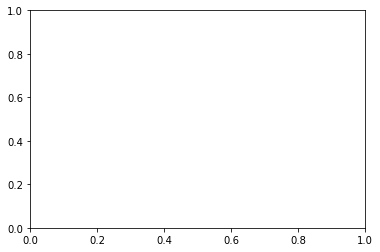

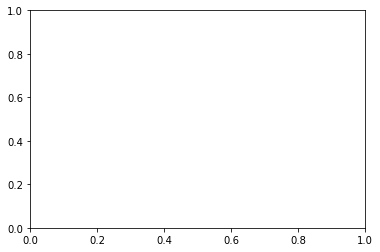

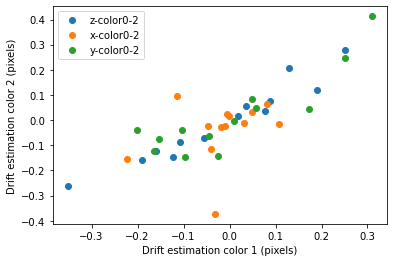

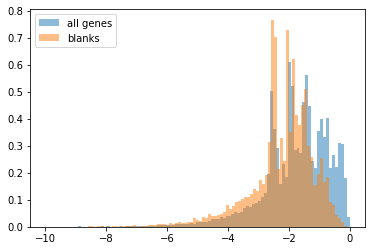

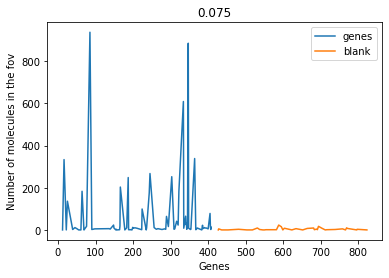

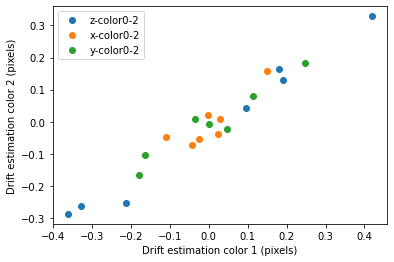

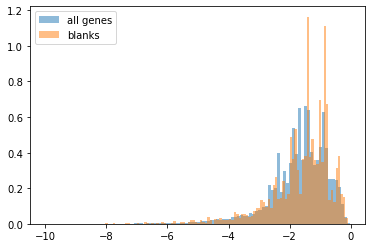

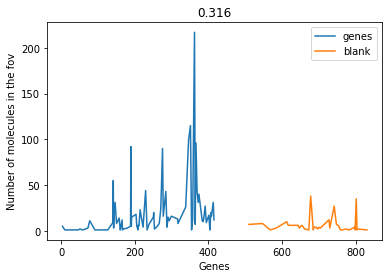

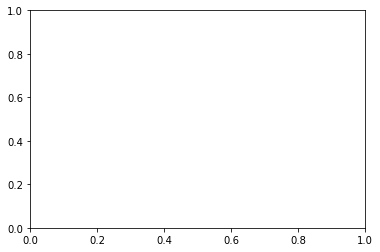

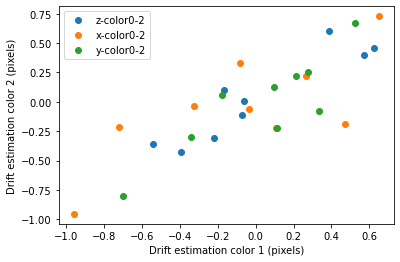

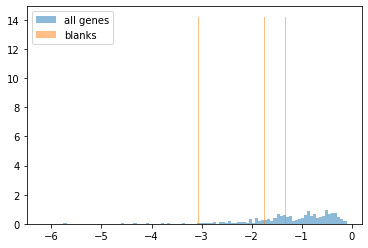

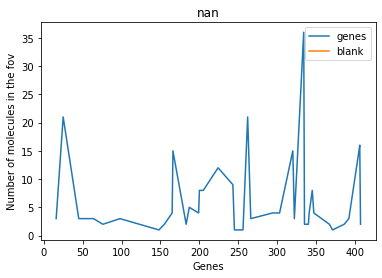

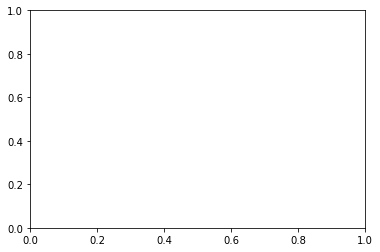

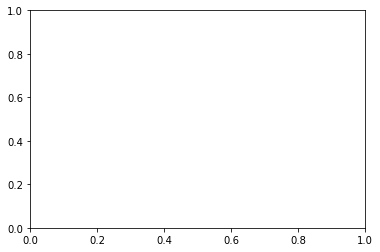

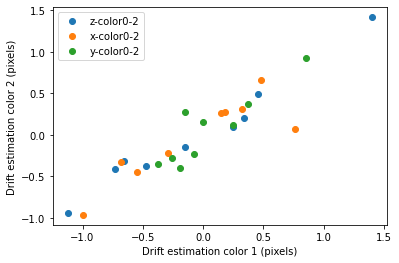

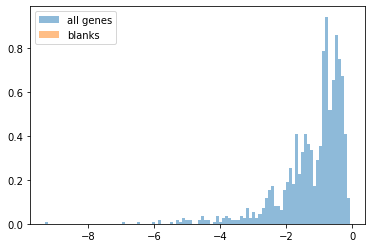

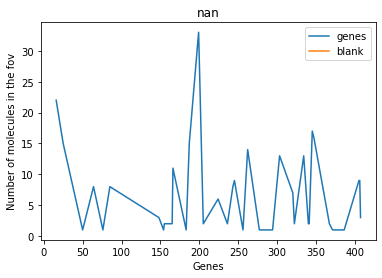

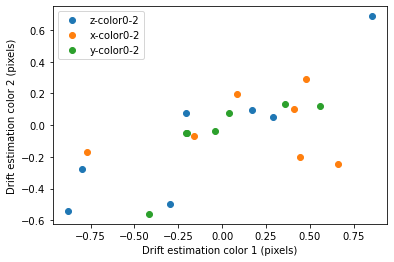

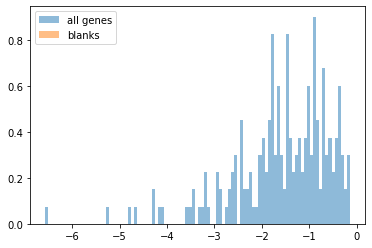

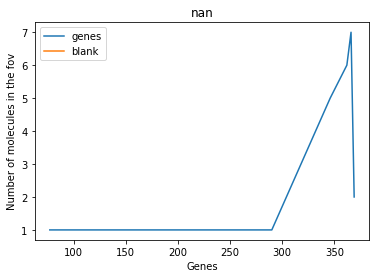

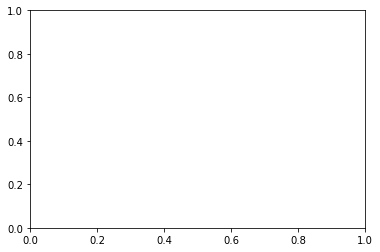

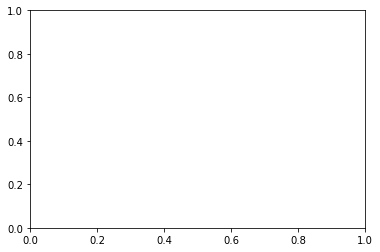

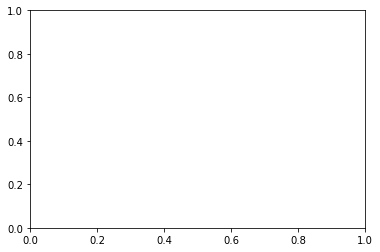

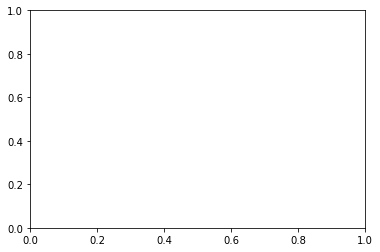

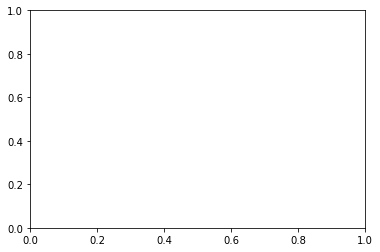

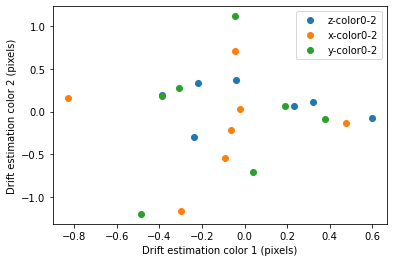

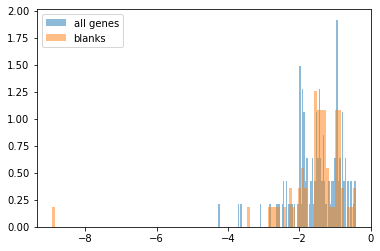

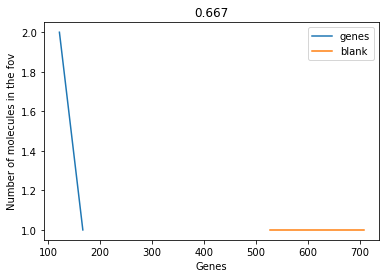

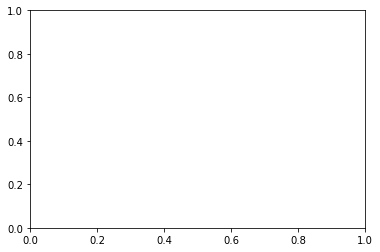

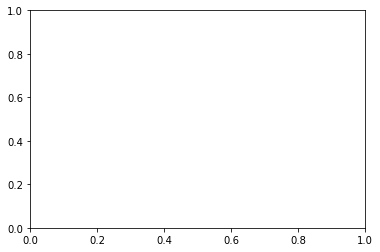

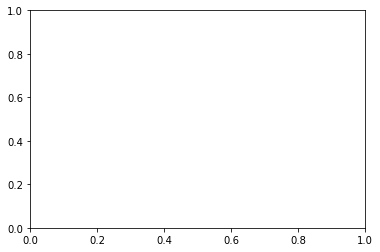

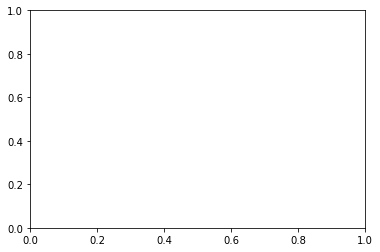

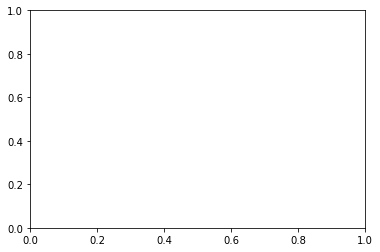

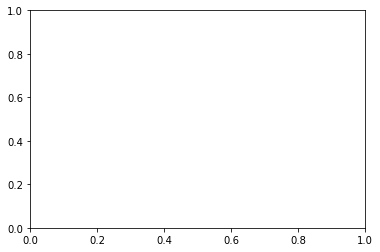

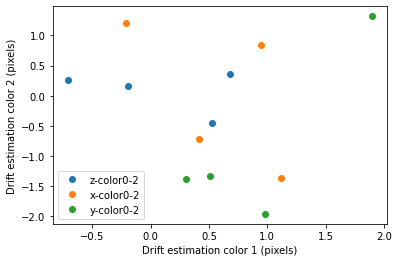

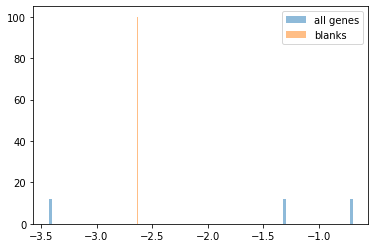

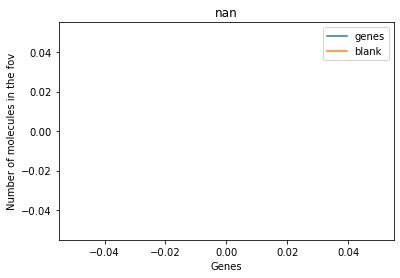

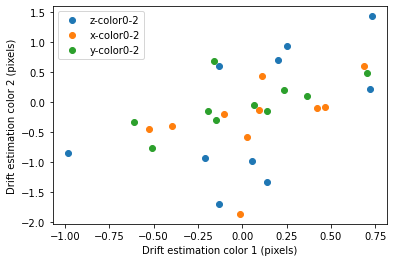

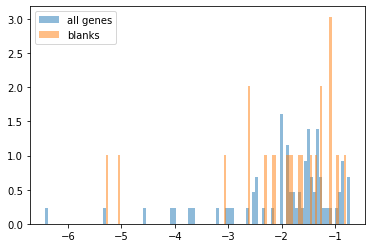

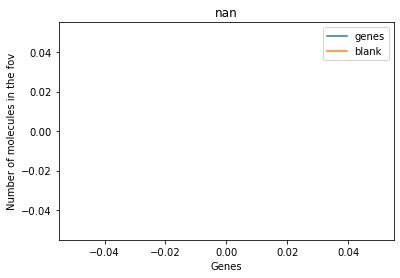

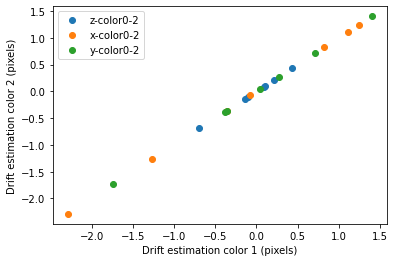

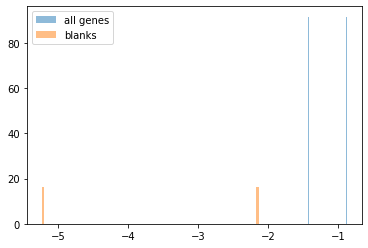

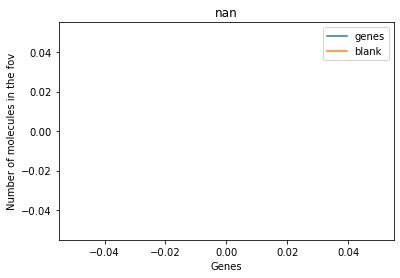

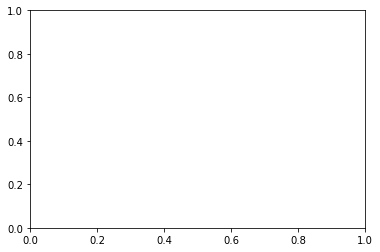

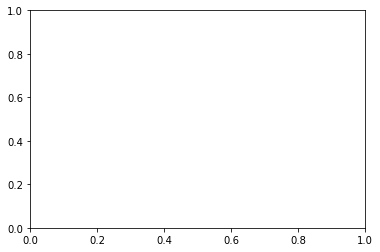

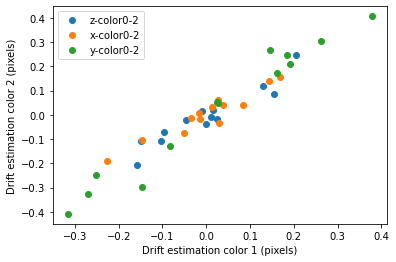

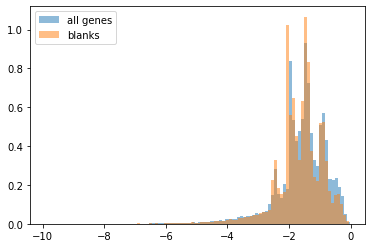

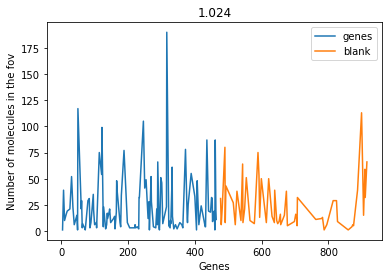

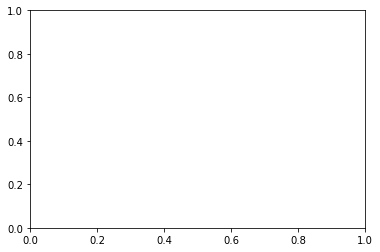

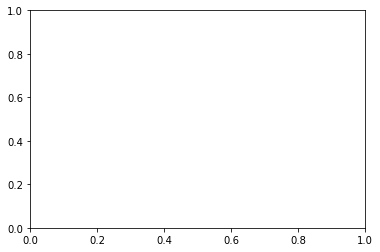

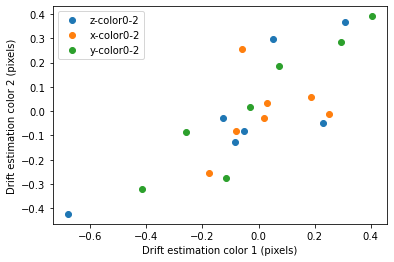

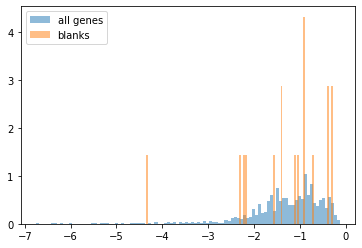

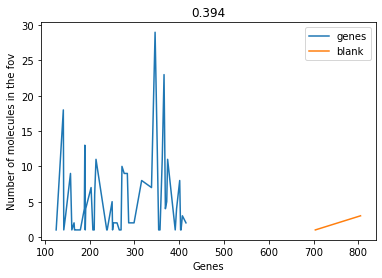

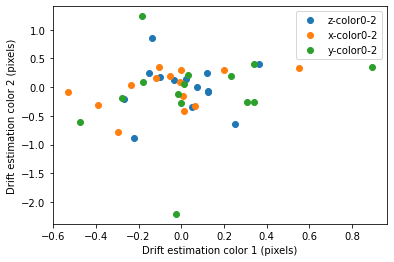

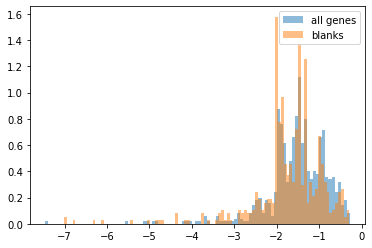

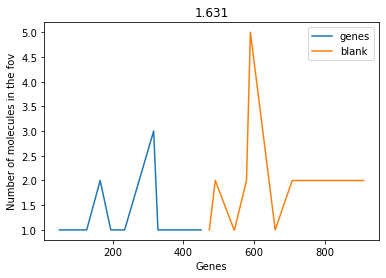

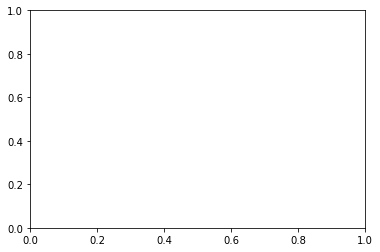

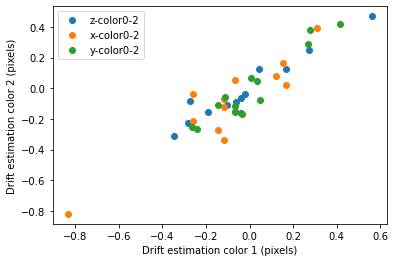

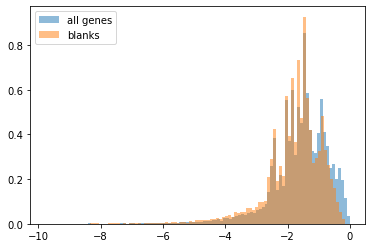

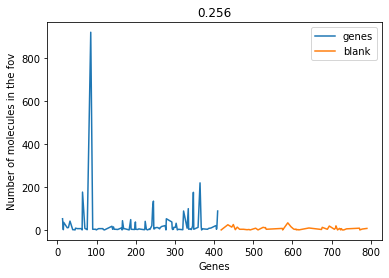

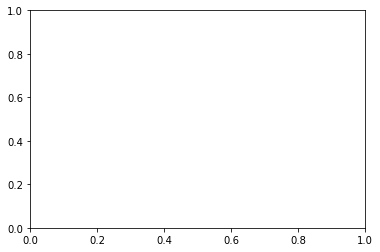

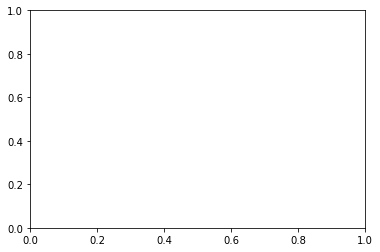

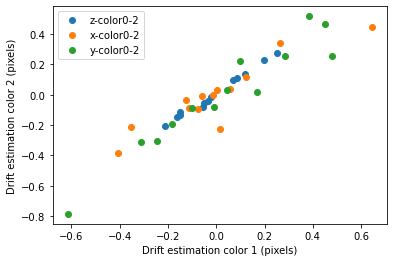

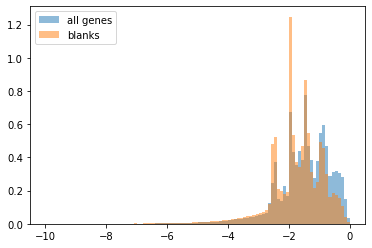

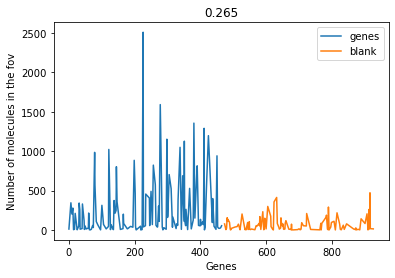

In [6]:
for fov,set_,save_folder in tqdm(paramaters):
    try:
        main_analysisV1(fov,set_,
                       save_folder = save_folder,
                       save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                       save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                       drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                       segm_tag = 'A1_LamA_Nup98')
    except:
        print("Failed at:",fov,set_,save_folder)

### Load library information

In [7]:
tags_lib = ['-e1','-e2','-p12','-p34','-p56','-p711']
fls_lib = ['C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevEP1-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevEP2-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP1P2-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP3P4-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP5P6-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP7P11-code_color2__comb16-4-4.csv']
namesf = []
namesflib = []
for fl_l,tag_l in zip(fls_lib,tags_lib):
    dfL = pd.read_csv(fl_l)
    namesf+=[nm+tag_l if 'blank' in nm else nm for nm in dfL['name']]
    namesflib+=[nm+'--'+tag_l for nm in dfL['name']]
genesf = np.unique(namesf)
dic_nmlib_index = dict(zip(genesf,np.arange(len(genesf))))

dic_libs = {}
for gn in namesflib:
    gn_,lib_ = gn.split('---')[0],gn.split('---')[-1]
    if gn_ not in dic_libs: dic_libs[gn_]=[]
    dic_libs[gn_].append(lib_)


### Load the cell info first - fast

In [ ]:
save_fls_ = glob.glob(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--*')

In [ ]:
#dic_cells = {}
#dic_cells_alt={}
cells_all = None
keys = []
for save_fl in tqdm(save_fls_[:]):
    #save_fl = save_fls_[0]
    dic = np.load(save_fl)
    cells = dic['cellinfo'][1:]
    header_cells = list(dic['header_cells'])
   
    vols = cells[:,header_cells.index('volm')]

    icellsf = cells[:,0].astype(int)
    vols = cells[:,header_cells.index('volm')]
    
    vol_th_ = vols>4000
    icellsf = icellsf[vol_th_]
    cells = cells[vol_th_]
    base = os.path.basename(save_fl).split('--')[-2]+'_'
    keys.extend([base+str(int(cell)) for cell in cells[:,0]])
    cells_all = cells if cells_all is None else np.concatenate([cells_all,cells],axis=0)

    
volms = cells_all[:,1]
index = np.argsort(volms)[::1]
keys_ = np.array(keys)[index]
cells_all_=cells_all[index]
dice_cells = dict(zip(keys_,cells_all_))
keysF = np.array(list(dice_cells.keys()))
Xcells = np.array([dice_cells[cell][[0,-3,-2,-1]]for cell in keysF])

tree = cKDTree(Xcells)
res = tree.query_ball_tree(tree,20)
res_ = []
indCells = Xcells[:,0]

for ir,r in enumerate(tqdm(res)):
    ind_ = indCells[r]
    res_.append(np.array(r)[ind_==indCells[ir]])
dic_match={}
for ir,r in enumerate(res_):
    for r_ in r:
        dic_match[keysF[ir]]=keysF[r_]

### Load cell by gene in df

In [ ]:
#df will be of size genesf and cellidsf
#cell_df,df=None,None
dfF = None
cell_dfF = None
counter=0
dic_cells = {}
cellidsf = []
df = np.zeros([0,len(genesf)])

for save_fl in tqdm(save_fls_[:]):
    #save_fl = save_fls_[0]
    dic = np.load(save_fl)
    XF = dic['XF']
    header = list(dic['header'])
    genes_decoded = dic['genes']
    cells = dic['cellinfo'][1:]
    header_cells = list(dic['header_cells'])
    ### Rethrehold based on score
    iscore = list(header).index('score')
    scoreA = XF[:,iscore]
    keep = scoreA>-0.5



    icell = header.index('cell_id')

    icells = XF[keep,icell].astype(int)
    vols = cells[:,header_cells.index('volm')]

    icellsf = cells[:,0].astype(int)
    vols = cells[:,header_cells.index('volm')]
    
    vol_th_ = vols>4000
    icellsf = icellsf[vol_th_]
    cells = cells[vol_th_]
    
    
    
    
    keep_vol = np.in1d(icells,icellsf) ### is molecule part of a big enough cell
    icells=icells[keep_vol] #final cell indexes of the molecules
    
    base_cell = os.path.basename(save_fl).split('--')[-2]+'_'
    icells_match = np.array([dic_match[base_cell+str(int(icell))]for icell in icells])
    
    ugns,gns_i = np.unique(genes_decoded[keep][keep_vol],return_inverse=True)
    
    
    
    icells_unique,icells_inv = np.unique(icells_match,return_inverse=True)
    #icells_unique = list(icells_unique)+list(np.setdiff1d(icellsf,icells_unique))### add back in the 0 count cells
    #icells_unique = np.array(icells_unique)
    mcell = len(icells_unique)#+1
    gn_cell,gn_cell_cts = np.unique(mcell*gns_i+icells_inv,return_counts=True)
    igns_ = gn_cell//mcell
    icells_ = gn_cell%mcell
    Mcts = np.zeros([mcell,len(ugns)])
    Mcts[icells_,igns_]=gn_cell_cts
    
    _,plate,fov,set_ = os.path.basename(save_fl).split('--')
    plate = plate.lower().split('analysis')[-1]
    ugns_ = [gn+'-'+plate if 'blank' in gn else gn for gn in ugns]
    igns = [dic_nmlib_index[gn] for gn in ugns_]
    
    #icells_unique
    in_common_cells = np.in1d(icells_unique,cellidsf)#,assume_unique=True)
    cellidsf_dic = dict(zip(cellidsf,np.arange(len(cellidsf))))
    in_common_cells_f = np.array([cellidsf_dic[cell_] for cell_ in icells_unique[in_common_cells]],dtype=int)
    #in_common_cells_f = np.in1d(cellidsf,icells_unique)#,assume_unique=True)
    vals = np.zeros([np.sum(in_common_cells),len(genesf)])
    prev_vals = df[in_common_cells_f][:,igns]
    vals[:,igns] = np.max([Mcts[in_common_cells],prev_vals],axis=0)
    if np.sum(in_common_cells_f)>0:
        df[in_common_cells_f] = np.max([vals,df[in_common_cells_f]],axis=0)
    
    #df[in_common_cells_f][:,igns] = np.max([df[in_common_cells_f][:,igns],Mcts[in_common_cells]],axis=0)
    not_in_common_cells = ~in_common_cells
    extra_df = np.zeros([np.sum(not_in_common_cells),len(genesf)])
    extra_df[:,igns]=Mcts[not_in_common_cells]
    df = np.concatenate([df,extra_df])
    cellidsf+=list(icells_unique[not_in_common_cells])
    

### Save dataframes

In [ ]:

len(cellidsf)
dff = pd.DataFrame(df,columns=genesf,index=cellidsf)
cell_df = np.array([dice_cells.get(cell,[0]*len(header_cells)) for cell in cellidsf])
cell_df = pd.DataFrame(cell_df,columns=header_cells,index=cellidsf)
dff.to_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\dff_D16_0p5th.pkl')
cell_df.to_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\cell_df_D16_0p5th.pkl')

### Load and visiualize dataframes

In [9]:
import sys
sys.path.append(r'..//')
from ioMicro import *
import pandas as pd

In [10]:
dff = pd.read_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\dff_D16_0p5th.pkl')
cell_df = pd.read_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\cell_df_D16_0p5th.pkl')

In [27]:
def plot_gene_mosaic_cells(df,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20,viewer=None):
    cell_df_ = cell_df
    xcells,ycells=cell_df_['x_um_abs'],cell_df_['y_um_abs']
    Xcells = np.array([xcells*flipx,ycells*flipy][::transpose]).T
    vols = cell_df_['volm']
    
    cts = np.array(df[gene])#Ptbp1_smFISH
    cts[np.isnan(cts)]=0
    cts = cts/vols*np.median(vols)
    
    ncts = np.clip(cts/nmax,0,1)
    size = sz_min+ncts*(sz_max-sz_min)
    from matplotlib import cm as cmap
    cols = cmap.coolwarm(ncts)
    import napari
    good_cells = slice(None)
    good_cells = np.argsort(cts)
    names_cells = np.array(list(dff.index))[good_cells]
    XC = -Xcells[good_cells,::-1]
    if viewer is None:
        viewer = napari.view_points(XC,size=size[good_cells],face_color=cols[good_cells],name=gene)
    else:
        viewer.add_points(XC,size=size[good_cells],face_color=cols[good_cells],name=gene)
    if plt_fov:
        #ifovs = np.array(list(df.index),dtype=int)//10**5
        ifovs = [int(nm.split('_')[-2]) for nm in names_cells]
        ifov_unk = np.unique(ifovs)
        Xfov = np.array([np.mean(XC[ifovs==ifov],axis=0)for ifov in ifov_unk])
        features =  {'fov':ifov_unk}
        text = {
            'string': '{fov:.0f}',
            'size': 20,
            'color': 'gray',
            'translation': np.array([0, 0]),
        }
        viewer.add_points(Xfov,text=text,features=features,edge_width=0)
    return viewer

In [36]:
svfld =r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\images'
#gene = 'Aif1'
#viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20);
gene = 'P2ry12'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20)
gene = 'Csf1r'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
gene = 'Tmem119'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
gene = 'Cx3cr1'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
if False:
    im = viewer.screenshot(size=(5000,5000))
    viewer.close()
    cv2.imwrite(svfld+os.sep+gene+'_D16.png',im[:,:,[2,1,0,3]])

In [24]:
gns_all = np.sort([gn for gn in dff.columns if 'blank' not in gn])
print(list(gns_all))

['1110008P14Rik', '1500015O10Rik', '1810041L15Rik', '2310069B03Rik', '2610528A11Rik', '2900055J20Rik', '3110035E14Rik', '4833407H14Rik', '4930570B17Rik', '6330403K07Rik', '9630013A20Rik', 'A1cf', 'A230050P20Rik', 'A830009L08Rik', 'A930003A15Rik', 'Abca8a', 'Abcb1b', 'Abcb4', 'Abcg1', 'Abhd15', 'Abhd2', 'Abi3', 'Abi3bp', 'Acer3', 'Ache', 'Acsl3', 'Acta2', 'Actg1', 'Adamts1', 'Adamts5', 'Adamts9', 'Adamtsl4', 'Adarb2', 'Adcy1', 'Adcy2', 'Adcyap1', 'Adgra2', 'Adgrd1', 'Adgre1', 'Adgrl3', 'Adh1', 'Adora2a', 'Adora3', 'Afap1l2', 'Afp', 'Agpat2', 'Agrp', 'Agt', 'Ahcyl2', 'Ahi1', 'Ahnak', 'Aif1', 'Aif1l', 'Akain1', 'Alas2', 'Alb', 'Aldh1a1', 'Aldh1a2', 'Aldh1a7', 'Aldh1l1', 'Aldoa', 'Aldoc', 'Alox12', 'Alox5ap', 'Alx1', 'Alyref', 'Ambra1', 'Amd2', 'Amot', 'Amz1', 'Angpt1', 'Ank2', 'Ankk1', 'Ankrd11', 'Anks6', 'Anln', 'Anp32e', 'Anxa2', 'Anxa5', 'Aoah', 'Ap3s1', 'Apln', 'Apoa1', 'Apoa2', 'Apoc2', 'Apod', 'Apoe', 'Apoo', 'Aqp1', 'Aqp2', 'Aqp3', 'Aqp4', 'Aqp8', 'Arg1', 'Arhgap10', 'Arhgap27', 'A

In [37]:
len(gns_all)

2042

In [42]:
svfld =r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\images'
if not os.path.exists(svfld): os.makedirs(svfld)
    
gene = 'Acsl'
for gene in [gn for gn in gns_all if 'Foxj1' in gn]:
#for gene in ['Malat1', 'H19', 'Col1a1', 'Dpysl3', 'Meg3', 'Ptprs', 'Mapt', 'Dpysl2', 'Gnb1', 'Ywhae', 'Col3a1', 'Sox4', 'Nfix', 'Serpinh1', 'Sparc', 'Agt', 'Nedd4', 'Nnat', 'Ina', 'Xist', 'Uchl1', 'Islr2', 'Igfbpl1', 'Elavl3', 'Sdc3', 'Rab6b', 'Gpm6a', 'Cntf', 'Ndn', 'Csdc2']:
    viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20)
    im = viewer.screenshot(size=(5000,5000))
    viewer.close()
    cv2.imwrite(svfld+os.sep+gene+'_D16.png',im[:,:,[2,1,0,3]])

In [32]:
'Tmem119' in gns_all

True

In [ ]:
TMEM119